# Dataset Generation Pipeline

This notebook processes and cleans multiple data sources to create a unified dataset for analysis. The pipeline handles:

1. **Water consumption data** (`consum_telelectura_v2.parquet`) - Daily water consumption readings
2. **Leak incident data** (`consum_avisos_missatges_v2.parquet`) - Water leak reports and messages
3. **Weather data** (`Dades_meteorològiques_diàries_de_la_XEMA`) - Daily meteorological measurements
4. **Socioeconomic index** (`ist_per_seccio_censal.csv`) - Territorial socioeconomic index by census section

All data is filtered to Barcelona (census sections starting with 8019/08019) and processed in chunks to handle large file sizes efficiently.


## 1. Setup

Import required libraries and establish database connection. We use DuckDB for efficient data loading and pandas for data manipulation.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import duckdb
con = duckdb.connect()

## 2. Data Loading

Load and inspect all raw data sources. We use DuckDB to efficiently read large parquet files without loading everything into memory at once. This allows us to check data sizes and sample records before processing.


### 2.1 Water Consumption Data

The consumption dataset contains daily water meter readings. We check the total number of records and inspect a sample to understand the data structure.


In [3]:
# Check consumption data size and sample
# We'll load data only when needed for pandas operations
print("Checking consum data...")
row_count = con.execute("SELECT COUNT(*) as count FROM 'data/consum_telelectura_v2.parquet'").df()['count'].iloc[0]
print(f"Total rows in consum: {row_count:,}")

# Load a sample for inspection
df_consum_sample = con.execute("SELECT * FROM 'data/consum_telelectura_v2.parquet' LIMIT 5").df()
print("\nSample data:")
df_consum_sample.head()

Checking consum data...
Total rows in consum: 17,112,709

Sample data:


,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,SECCIO_CENSAL,US_AIGUA_GEST,NUM_MUN_SGAB,NUM_DTE_MUNI,NUM_COMPLET,DATA_INST_COMP,MARCA_COMP,CODI_MODEL,DIAM_COMP
0,VECWAVDUULZDSBOP,2021-01-01,1758,801903025,C,0,3,D15TD031058M,2016-04-25,ITR,23,30
1,VECWAVDUULZDSBOP,2021-01-02,1854,801903025,C,0,3,D15TD031058M,2016-04-25,ITR,23,30
2,VECWAVDUULZDSBOP,2021-01-03,1885,801903025,C,0,3,D15TD031058M,2016-04-25,ITR,23,30
3,VECWAVDUULZDSBOP,2021-01-04,5676,801903025,C,0,3,D15TD031058M,2016-04-25,ITR,23,30
4,VECWAVDUULZDSBOP,2021-01-05,4456,801903025,C,0,3,D15TD031058M,2016-04-25,ITR,23,30


### 2.2 Leak Incidents Data

The leak incidents dataset contains water leak reports and messages. This is a very large dataset (over 76 million rows), so we'll process it in chunks.


In [4]:
# Check leak incidents data size and sample
print("Checking fuites data...")
row_count = con.execute("SELECT COUNT(*) as count FROM 'data/consum_avisos_missatges_v2.parquet'").df()['count'].iloc[0]
print(f"Total rows in fuites: {row_count:,}")

# Load a sample for inspection
df_fuites_sample = con.execute("SELECT * FROM 'data/consum_avisos_missatges_v2.parquet' LIMIT 5").df()
print("\nSample data:")
df_fuites_sample.head()

Checking fuites data...
Total rows in fuites: 76,372,248

Sample data:


,POLISSA_SUBM,DATA_INI_FACT,DATA_FIN_FACT,CREATED_MENSAJE,CODIGO_MENSAJE,TIPO_MENSAJE,US_AIGUA_SUBM,SECCIO_CENSAL,NUMEROSERIECONTADOR,CONSUMO_REAL,FECHA_HORA
0,RGYFWIZ4ZRRZKX2K,2023-09-13 00:00:00,2023-11-14 00:00:00,NaT,None,None,DOMÈSTIC,0801907090,IBAJ44VHSIRRTASA,NaN,2024-01-01
1,HHB4U5HUQKW7IOGD,2023-08-13 00:00:00,2023-10-16 00:00:00,NaT,None,None,DOMÈSTIC,0801909040,L2CLPPJRIPAEESV7,NaN,2024-01-01
2,EU6AT3IKPUKCZTBU,2024-01-24 00:00:00,2024-03-26 00:00:00,NaT,None,None,DOMÈSTIC,0801902046,45TBDJQN4LA37ZIN,NaN,2024-01-01
3,EU6AT3IKPUKCZTBU,2023-11-27 00:00:00,2024-01-24 00:00:00,NaT,None,None,DOMÈSTIC,0801902046,45TBDJQN4LA37ZIN,NaN,2024-01-01
4,EWNDTPECBVEGW6AU,2023-09-29 00:00:00,2023-11-27 00:00:00,NaT,None,None,DOMÈSTIC,0801902046,VTRAI3L24SWKVC5H,NaN,2024-01-01


### 2.3 Socioeconomic Index Data

The socioeconomic index provides territorial indicators at the census section level, which will be used for joining with consumption and leak data.


In [5]:
# Dataset Índex Socioeconòmic Territorial per secció censal
print("Loading ist_per_seccio_censal.csv with DuckDB...")
df_socio = con.execute("""
    SELECT * FROM read_csv_auto('data/ist_per_seccio_censal.csv', 
                                 delim=';', 
                                 decimal_separator=',',
                                 header=true)
""").df()
print(f"Loaded {len(df_socio):,} rows")
df_socio.head()

Loading ist_per_seccio_censal.csv with DuckDB...
Loaded 5,092 rows


,any,secció censal,concepte,estat,valor
0,2022,25001901001,Índex socioeconòmic territorial,None,97.8
1,2022,08001801001,Índex socioeconòmic territorial,None,105.1
2,2022,08001801002,Índex socioeconòmic territorial,None,102.9
3,2022,08001801003,Índex socioeconòmic territorial,None,118.5
4,2022,08001801004,Índex socioeconòmic territorial,None,118.0


### 2.4 Weather Data

Weather data from XEMA (Catalan Meteorological Service) contains daily measurements from multiple weather stations. This data will be used to analyze correlations between weather patterns and water consumption/leaks.


In [6]:
# Load weather data using DuckDB
print("Loading dades meteorloògiques diàries with DuckDB...")
df_weather = con.execute("SELECT * FROM read_csv_auto('data/Dades_meteorològiques_diàries_de_la_XEMA_20251119.csv', header=true)").df()
print(f"Loaded {len(df_weather):,} rows")

df_weather.head()

Loading dades meteorloògiques diàries with DuckDB...
Loaded 129,301 rows


,ID,CODI_ESTACIO,NOM_ESTACIO,DATA_LECTURA,CODI_VARIABLE,NOM_VARIABLE,VALOR,UNITAT,HORA _TU,Estat
0,D51000012101,D5,Barcelona - Observatori Fabra,2021-01-01,1.000,Temperatura mitjana diària,"5,3",°C,<NA>,Representatiu
1,D51001012101,D5,Barcelona - Observatori Fabra,2021-01-01,1.001,Temperatura màxima diària + hora,"6,5",°C,13:06:00,Representatiu
2,D51002012101,D5,Barcelona - Observatori Fabra,2021-01-01,1.002,Temperatura mínima diària + hora,"3,1",°C,23:56:00,Representatiu
3,D51003012101,D5,Barcelona - Observatori Fabra,2021-01-01,1.003,Temperatura mitjana diària clàssica,"4,8",°C,<NA>,Representatiu
4,D51004012101,D5,Barcelona - Observatori Fabra,2021-01-01,1.004,Amplitud tèrmica diària,"3,4",°C,<NA>,Representatiu


## 3. Data Cleaning and Filtering

Process the raw data files to extract Barcelona-specific data and clean weather data. Since the datasets are very large, we process them in chunks (split files) to avoid memory issues. For consumption and leak data, we:

1. Filter to Barcelona census sections (8019/08019)
2. Transform census section codes to the standard 11-digit format
3. Keep only relevant columns
4. Save cleaned data:
   - Consumption: Split parquet files in `clean/split_consum_bcn/` (kept as splits due to size)
   - Leaks: Single parquet file `clean/fuites_clean_bcn.parquet` (one leak per row)

For weather data, we clean missing values and ensure consistent formatting.


### 3.1 Clean Consumption Data

Process consumption data split files:
- Filter to Barcelona (SECCIO_CENSAL starting with 8019)
- Transform census section codes: add '3' after 8019, then prepend '0' to get 11-digit format
- Keep relevant columns: POLIZA_SUMINISTRO, FECHA, CONSUMO_REAL, SECCIO_CENSAL, US_AIGUA_GEST, DATA_INST_COMP
- Convert date columns to datetime format
- Save cleaned Barcelona data as split parquet files: `clean/split_consum_bcn/consum_clean_bcn_part_*.parquet`


In [7]:
# df_consum
# Clean and filter df_consum data from split files

import glob
from pathlib import Path
from split_parquet import split_parquet_efficient

# Locate (or create) the directory that should contain the split chunks
split_dir = Path("data/split_consum")
split_dir.mkdir(parents=True, exist_ok=True)
split_pattern = "consum_telelectura_v2_part_*.parquet"
split_files = sorted(glob.glob(str(split_dir / split_pattern)))

if not split_files:
    raw_consum_file = Path("data/consum_telelectura_v2.parquet")
    if raw_consum_file.exists():
        print("No pre-split consumption files found. Splitting the raw file now (one-time operation)...")
        from split_parquet import split_parquet_efficient

        split_chunk_size = 1_000_000
        split_parquet_efficient(str(raw_consum_file), str(split_dir), chunk_size=split_chunk_size)
        split_files = sorted(glob.glob(str(split_dir / split_pattern)))
    else:
        print("⚠ No split files found and raw file 'data/consum_telelectura_v2.parquet' is missing.")
        split_files = []

if not split_files:
    raise FileNotFoundError("Unable to locate consumption split files even after attempting to split the raw file.")

print(f"Found {len(split_files)} split files to process")
print("-" * 80)

# Create output directory for cleaned files
output_dir = Path("clean/split_consum_bcn")
output_dir.mkdir(parents=True, exist_ok=True)

# Keep only relevant columns
cols_keep_consum = [
    'POLIZA_SUMINISTRO', 'FECHA', 'CONSUMO_REAL', 'SECCIO_CENSAL', 'US_AIGUA_GEST', 'DATA_INST_COMP'
]

# Track statistics
total_rows_processed = 0
total_rows_bcn = 0
total_duplicates_removed = 0

# Process each split file
for i, file_path in enumerate(split_files, 1):
    print(f"\nProcessing file {i}/{len(split_files)}: {Path(file_path).name}")
    
    # Load one split file
    df_chunk = pd.read_parquet(file_path)
    total_rows_processed += len(df_chunk)
    
    # Convert FECHA and DATA_INST_COMP to datetime
    for date_col in ["FECHA", "DATA_INST_COMP"]:
        if date_col in df_chunk.columns:
            df_chunk[date_col] = pd.to_datetime(df_chunk[date_col], errors="coerce")
    
    # Keep only relevant columns
    df_chunk_relevant = df_chunk[cols_keep_consum].copy()
    
    # Create df_consum_bcn: First filter to keep only rows where SECCIO_CENSAL starts with 8019
    # Convert SECCIO_CENSAL to string to check if it starts with 8019
    df_chunk_relevant['SECCIO_CENSAL'] = df_chunk_relevant['SECCIO_CENSAL'].astype(str)
    mask_bcn = df_chunk_relevant['SECCIO_CENSAL'].str.startswith('8019', na=False)
    df_chunk_bcn = df_chunk_relevant[mask_bcn].copy()
    
    # Then transform SECCIO_CENSAL: add 3 after 8019, then add 0 before all digits to get 11-digit strings
    df_chunk_bcn['SECCIO_CENSAL'] = df_chunk_bcn['SECCIO_CENSAL'].str.replace('^8019', '80193', regex=True)
    df_chunk_bcn['SECCIO_CENSAL'] = '0' + df_chunk_bcn['SECCIO_CENSAL']
    
    # Remove duplicates (same POLIZA_SUMINISTRO + FECHA) within the chunk
    dup_mask = df_chunk_bcn.duplicated(subset=['POLIZA_SUMINISTRO', 'FECHA'], keep='first')
    dup_count = dup_mask.sum()
    if dup_count > 0:
        print(f"  - Dropping {dup_count:,} duplicate rows (same POLIZA_SUMINISTRO + FECHA)")
        total_duplicates_removed += dup_count
        df_chunk_bcn = df_chunk_bcn.drop_duplicates(subset=['POLIZA_SUMINISTRO', 'FECHA'], keep='first')
    
    # Save cleaned split file
    output_file = output_dir / f"consum_clean_bcn_part_{i:03d}.parquet"
    df_chunk_bcn.to_parquet(output_file, index=False)
    
    total_rows_bcn += len(df_chunk_bcn)
    print(f"Processed {len(df_chunk):,} rows → {len(df_chunk_bcn):,} Barcelona rows")
    print(f"Saved to {output_file.name}")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total rows processed: {total_rows_processed:,}")
print(f"Total Barcelona rows (after filtering & dedup): {total_rows_bcn:,}")
print(f"Total duplicate rows removed (POLIZA_SUMINISTRO + FECHA): {total_duplicates_removed:,}")
print(f"Cleaned files saved to: {output_dir}/")
print(f"\nFirst rows sample from last processed file:")
print(df_chunk_bcn.head())

Found 18 split files to process
--------------------------------------------------------------------------------

Processing file 1/18: consum_telelectura_v2_part_001.parquet
  - Dropping 1 duplicate rows (same POLIZA_SUMINISTRO + FECHA)
Processed 1,000,000 rows → 24,725 Barcelona rows
Saved to consum_clean_bcn_part_001.parquet

Processing file 2/18: consum_telelectura_v2_part_002.parquet
  - Dropping 2 duplicate rows (same POLIZA_SUMINISTRO + FECHA)
Processed 1,000,000 rows → 142,432 Barcelona rows
Saved to consum_clean_bcn_part_002.parquet

Processing file 3/18: consum_telelectura_v2_part_003.parquet
  - Dropping 4 duplicate rows (same POLIZA_SUMINISTRO + FECHA)
Processed 1,000,000 rows → 127,911 Barcelona rows
Saved to consum_clean_bcn_part_003.parquet

Processing file 4/18: consum_telelectura_v2_part_004.parquet
  - Dropping 1 duplicate rows (same POLIZA_SUMINISTRO + FECHA)
Processed 1,000,000 rows → 68,311 Barcelona rows
Saved to consum_clean_bcn_part_004.parquet

Processing file 

In [8]:
# Verify duplicates across all cleaned consumption chunks (POLIZA_SUMINISTRO + FECHA)
print("\nVerifying duplicates across cleaned consumption chunks...")
cleaned_files = sorted(glob.glob(str(output_dir / "consum_clean_bcn_part_*.parquet")))
combined_df = []
for fp in cleaned_files:
    combined_df.append(pd.read_parquet(fp, columns=['POLIZA_SUMINISTRO', 'FECHA']))
combined_df = pd.concat(combined_df, ignore_index=True)
combined_df['FECHA'] = pd.to_datetime(combined_df['FECHA'], errors='coerce')

global_dup_mask = combined_df.duplicated(subset=['POLIZA_SUMINISTRO', 'FECHA'], keep=False)
num_global_dups = global_dup_mask.sum()
if num_global_dups == 0:
    print("✓ No duplicates remain across cleaned chunks")
else:
    print(f"⚠ Found {num_global_dups:,} duplicate rows across cleaned chunks")
    dup_examples = combined_df[global_dup_mask].head()
    print("Sample duplicates:")
    print(dup_examples)


Verifying duplicates across cleaned consumption chunks...
✓ No duplicates remain across cleaned chunks


In [9]:
# Detailed duplicate summary across all cleaned chunks
print("\nDetailed duplicate summary (POLIZA_SUMINISTRO + FECHA)...")
cleaned_files = sorted(glob.glob(str(output_dir / "consum_clean_bcn_part_*.parquet")))
combined_df = []
for fp in cleaned_files:
    combined_df.append(pd.read_parquet(fp, columns=['POLIZA_SUMINISTRO', 'FECHA']))
combined_df = pd.concat(combined_df, ignore_index=True)
combined_df['FECHA'] = pd.to_datetime(combined_df['FECHA'], errors='coerce')

consum_dup_groups = (
    combined_df
    .groupby(['POLIZA_SUMINISTRO', 'FECHA'])
    .size()
    .reset_index(name='count')
)
consum_dup_groups = consum_dup_groups[consum_dup_groups['count'] > 1]
num_dup_pairs = len(consum_dup_groups)
num_global_dups = int((consum_dup_groups['count'] - 1).sum())

if num_dup_pairs == 0:
    print("✓ No duplicate pairs detected across cleaned chunks")
else:
    print(f"⚠ Detected {num_global_dups:,} duplicate rows spread across {num_dup_pairs:,} (POLIZA, FECHA) pairs")
    print("Sample duplicate pairs (with multiplicity):")
    print(consum_dup_groups.head())




Detailed duplicate summary (POLIZA_SUMINISTRO + FECHA)...
✓ No duplicate pairs detected across cleaned chunks


In [10]:
# Global deduplication across chunks (if needed)
from pathlib import Path
import duckdb

chunk_size = 1_000_000
if 'num_global_dups' not in globals():
    raise RuntimeError("Run the duplicate summary cell first to populate num_global_dups.")

if num_global_dups == 0:
    print("No global deduplication required — dataset already unique per (POLIZA, FECHA).")
else:
    print(f"Running global deduplication... removing {num_global_dups:,} rows.")
    query = """
        SELECT *
        FROM (
            SELECT *,
                   ROW_NUMBER() OVER (PARTITION BY POLIZA_SUMINISTRO, FECHA ORDER BY FECHA, SECCIO_CENSAL) AS rn
            FROM read_parquet('clean/split_consum_bcn/consum_clean_bcn_part_*.parquet')
        )
        WHERE rn = 1
    """
    dedup_df = duckdb.sql(query).to_df()

    # Remove old split files so we can overwrite with the original naming scheme
    print("Replacing split files with globally deduped data...")
    for fp in output_dir.glob("consum_clean_bcn_part_*.parquet"):
        fp.unlink()

    num_parts = 0
    for start in range(0, len(dedup_df), chunk_size):
        num_parts += 1
        chunk = dedup_df.iloc[start:start + chunk_size]
        output_file = output_dir / f"consum_clean_bcn_part_{num_parts:03d}.parquet"
        chunk.to_parquet(output_file, index=False)
        print(f"  - Wrote {len(chunk):,} rows to {output_file.name}")

    print("✓ Global dedup complete. Re-run the verification cell to confirm zero duplicates.")



No global deduplication required — dataset already unique per (POLIZA, FECHA).


### 3.2 Clean Leak Incidents Data

Workflow:
1. **Prepare split files**: ensure `data/consum_avisos_missatges_v2.parquet` is split into manageable chunks (or reuse existing splits).
2. **Quantify duplication**: scan the splits to count records per `POLISSA_SUBM` and capture an example (e.g., `2ORT36IXOVU5ZTPP`) showing that multiple rows on the same day differ only by seconds. This justifies removing the time component and deduplicating by policy/date.
3. **Clean each split**:
   - Drop rows where both `CODIGO_MENSAJE` and `CREATED_MENSAJE` are missing.
   - Keep only rows with `CODIGO_MENSAJE = "FUITA"` (ignore reiterations and other codes).
   - Convert `CREATED_MENSAJE` to datetime, strip the time (keep only the date), and discard invalid timestamps.
   - Deduplicate by (`POLISSA_SUBM`, date) so that each leak is counted once per day.
   - Filter to Barcelona census sections (codes starting with `08019`), then standardize them by inserting `3` after `08019`.
   - Keep only the relevant columns: `POLISSA_SUBM`, `CREATED_MENSAJE`, `CODIGO_MENSAJE`, `US_AIGUA_SUBM`, `SECCIO_CENSAL`.
4. **Combine + save**: concatenate all cleaned chunks, enforce a final deduplication, and write the Barcelona dataset to `clean/fuites_clean_bcn.parquet`.

**Result**: One leak per policy per day with consistent census codes and no redundant reiteration logs.


In [11]:
# Ensure leak (avisos) data is split into manageable parquet chunks

import glob
from pathlib import Path

split_dir_avisos = Path("data/split_avisos")
split_dir_avisos.mkdir(parents=True, exist_ok=True)
split_pattern_avisos = "consum_avisos_missatges_v2_part_*.parquet"
split_files_avisos = sorted(glob.glob(str(split_dir_avisos / split_pattern_avisos)))

if not split_files_avisos:
    raw_avisos_file = Path("data/consum_avisos_missatges_v2.parquet")
    if raw_avisos_file.exists():
        print("No pre-split leak files found. Splitting the raw avisos file now (one-time operation)...")
        from split_parquet import split_parquet_efficient

        split_chunk_size = 1_000_000
        split_parquet_efficient(str(raw_avisos_file), str(split_dir_avisos), chunk_size=split_chunk_size)
        split_files_avisos = sorted(glob.glob(str(split_dir_avisos / split_pattern_avisos)))
    else:
        raise FileNotFoundError("Raw leak file 'data/consum_avisos_missatges_v2.parquet' not found. Please download it before continuing.")

print(f"Leak split files ready: {len(split_files_avisos)} files stored in {split_dir_avisos}")


Leak split files ready: 77 files stored in data/split_avisos


In [12]:
# Identify POLISSA_SUBM distributions and capture a concrete same-day duplicate example

from collections import Counter
from IPython.display import display

if 'split_files_avisos' not in globals() or not split_files_avisos:
    raise RuntimeError("Run the leak split preparation cell first to populate split_files_avisos.")

required_count = 1_000
polissa_counter = Counter()
example_polissa = None
example_rows = None

for file_path in split_files_avisos:
    df_chunk = pd.read_parquet(
        file_path,
        columns=['POLISSA_SUBM', 'CREATED_MENSAJE', 'CODIGO_MENSAJE', 'US_AIGUA_SUBM']
    )
    df_chunk = df_chunk.dropna(subset=['POLISSA_SUBM', 'CREATED_MENSAJE'])
    polissa_counter.update(df_chunk['POLISSA_SUBM'])
    
    if example_polissa is None:
        df_chunk['CREATED_MENSAJE'] = pd.to_datetime(df_chunk['CREATED_MENSAJE'], errors='coerce')
        df_chunk = df_chunk.dropna(subset=['CREATED_MENSAJE'])
        df_chunk['DATE_ONLY'] = df_chunk['CREATED_MENSAJE'].dt.date
        dup_mask = df_chunk.duplicated(subset=['POLISSA_SUBM', 'DATE_ONLY'], keep=False)
        candidate_dups = df_chunk[dup_mask]
        if not candidate_dups.empty:
            candidate_dups = candidate_dups.sort_values(['POLISSA_SUBM', 'DATE_ONLY', 'CREATED_MENSAJE'])
            for polissa, group in candidate_dups.groupby('POLISSA_SUBM'):
                if polissa_counter[polissa] >= required_count:
                    per_day = group.groupby('DATE_ONLY').filter(lambda x: x['CREATED_MENSAJE'].nunique() > 1)
                    if not per_day.empty:
                        example_polissa = polissa
                        example_rows = per_day[
                            ['POLISSA_SUBM', 'CREATED_MENSAJE', 'DATE_ONLY', 'CODIGO_MENSAJE', 'US_AIGUA_SUBM']
                        ].copy()
                        break
    if example_polissa is not None:
        break

if not polissa_counter:
    print("⚠ No POLISSA_SUBM values found in the split leak files.")
else:
    top_polissas = polissa_counter.most_common(5)
    summary_df = pd.DataFrame(top_polissas, columns=['POLISSA_SUBM', 'Row Count'])
    print("Examples of POLISSA_SUBM with more than 1000 records (before cleaning):")
    display(summary_df)
    
    if example_polissa is not None:
        example_rows = example_rows.sort_values(['DATE_ONLY', 'CREATED_MENSAJE'])
        print(
            f"\nExample: POLISSA_SUBM {example_polissa} has {polissa_counter[example_polissa]:,} total rows.\n"
            "The table below shows dates where multiple entries exist only minutes apart,"
            " so we drop the time component when deduplicating."
        )
        print(example_rows.to_string(index=False))
    else:
        print(
            "⚠ Unable to find an example with ≥1,000 rows showing same-day duplicate timestamps during this pass."
        )


Examples of POLISSA_SUBM with more than 1000 records (before cleaning):


,POLISSA_SUBM,Row Count
0,QEPJ3GL36LPH6JMU,49434
1,DAMY7FVE43ZAMQSK,47232
2,WA4OGB6DRPNVSPCR,34668
3,EYM5DNPZC22XQG6O,32571
4,PUPJA5U67MNHDCVR,22304



Example: POLISSA_SUBM 2ORT36IXOVU5ZTPP has 8,988 total rows.
The table below shows dates where multiple entries exist only minutes apart, so we drop the time component when deduplicating.
    POLISSA_SUBM     CREATED_MENSAJE  DATE_ONLY      CODIGO_MENSAJE US_AIGUA_SUBM
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-08-05 15:14:43 2023-08-05               FUITA      

While scanning the split leak files we found `POLISSA_SUBM` values such as `2ORT36IXOVU5ZTPP` that have multiple entries on the **same day** separated by only a few seconds:

```
2ORT36IXOVU5ZTPP 2023-10-10 15:37:42 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:42 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:42 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:42 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
2ORT36IXOVU5ZTPP 2023-10-10 15:37:43 2023-10-10 REITERACIÓ DE FUITA DOMÈSTIC
```

This pattern shows the same leak being logged several times within a few seconds. To avoid inflating leak counts we:

1. **Drop the time component** from `CREATED_MENSAJE` so that all entries from the same day collapse to a single date.
2. **Keep only one row per (`POLISSA_SUBM`, `CREATED_MENSAJE` date)**, eliminating exact duplicates that repeat even the same timestamp.

The cleaning cell below implements these two steps before saving the Barcelona-only leak dataset.


In [13]:
# df_fuites - Process split files one at a time to avoid memory issues
# Clean and filter df_fuites data from split files

import glob
from pathlib import Path

if 'split_files_avisos' in globals() and split_files_avisos:
    split_files = split_files_avisos
else:
    split_dir = Path("data/split_avisos")
    split_pattern = "consum_avisos_missatges_v2_part_*.parquet"
    split_files = sorted(glob.glob(str(split_dir / split_pattern)))
    if not split_files:
        raise FileNotFoundError("Leak split files were not found. Run the preparation cell above to generate them before continuing.")

print(f"Found {len(split_files)} split files to process")
print("=" * 80)

# Create output directory for cleaned files
output_dir = Path("clean")
output_dir.mkdir(parents=True, exist_ok=True)

# Keep only relevant columns
cols_keep_fuites = [
    'POLISSA_SUBM', 'CREATED_MENSAJE', 'CODIGO_MENSAJE',
    'US_AIGUA_SUBM', 'SECCIO_CENSAL'
]

# Track statistics
total_rows_processed = 0
total_rows_dropped_both_missing = 0
total_rows_dropped_fuita = 0
total_rows_dropped_duplicates = 0
total_rows_bcn = 0

# List to collect all cleaned data
fuites_clean_list = []

# Process each split file
for i, file_path in enumerate(split_files, 1):
    print(f"\nProcessing file {i}/{len(split_files)}: {Path(file_path).name}")
    
    # Load one split file
    df_chunk = pd.read_parquet(file_path)
    total_rows_processed += len(df_chunk)
    
    # Keep only relevant columns
    df_chunk_relevant = df_chunk[cols_keep_fuites].copy()
    
    # 1. Drop rows where both CODIGO_MENSAJE and CREATED_MENSAJE are missing
    mask_both_missing = df_chunk_relevant['CODIGO_MENSAJE'].isna() & df_chunk_relevant['CREATED_MENSAJE'].isna()
    rows_dropped = mask_both_missing.sum()
    total_rows_dropped_both_missing += rows_dropped
    df_chunk_relevant = df_chunk_relevant[~mask_both_missing].copy()
    
    # 2. Filter to keep only CODIGO_MENSAJE = "FUITA" (remove "REITERACIÓ DE FUITA" and others)
    mask_fuita = df_chunk_relevant['CODIGO_MENSAJE'] == 'FUITA'
    rows_before_fuita_filter = len(df_chunk_relevant)
    df_chunk_relevant = df_chunk_relevant[mask_fuita].copy()
    rows_dropped_fuita = rows_before_fuita_filter - len(df_chunk_relevant)
    
    # 3. Convert CREATED_MENSAJE to datetime and extract date only (year-month-day, no time)
    df_chunk_relevant['CREATED_MENSAJE'] = pd.to_datetime(df_chunk_relevant['CREATED_MENSAJE'], errors='coerce')
    # Drop rows where CREATED_MENSAJE is NaT (invalid dates)
    rows_before_date_filter = len(df_chunk_relevant)
    df_chunk_relevant = df_chunk_relevant[df_chunk_relevant['CREATED_MENSAJE'].notna()].copy()
    rows_dropped_invalid_date = rows_before_date_filter - len(df_chunk_relevant)
    # Extract date only (year-month-day, no time component)
    df_chunk_relevant['CREATED_MENSAJE'] = df_chunk_relevant['CREATED_MENSAJE'].dt.date
    
    # 4. Remove duplicates based on POLISSA_SUBM and CREATED_MENSAJE (date only)
    # This ensures one leak per row (one leak per POLISSA_SUBM per day)
    rows_before_dedup = len(df_chunk_relevant)
    df_chunk_relevant = df_chunk_relevant.drop_duplicates(subset=['POLISSA_SUBM', 'CREATED_MENSAJE'], keep='first')
    rows_dropped_duplicates = rows_before_dedup - len(df_chunk_relevant)
    
    # 5. Filter to keep only SECCIO_CENSAL starting with '08019' which corresponds to Barcelona
    df_chunk_relevant['SECCIO_CENSAL'] = df_chunk_relevant['SECCIO_CENSAL'].astype(str)
    mask_bcn_fuites = df_chunk_relevant['SECCIO_CENSAL'].str.startswith('08019', na=False)
    df_chunk_bcn = df_chunk_relevant[mask_bcn_fuites].copy()
    
    # 6. Transform SECCIO_CENSAL: add 3 after 08019 (no need to add 0, it's already included)
    df_chunk_bcn['SECCIO_CENSAL'] = df_chunk_bcn['SECCIO_CENSAL'].str.replace('^08019', '080193', regex=True)
    
    # Collect cleaned data
    fuites_clean_list.append(df_chunk_bcn)
    total_rows_bcn += len(df_chunk_bcn)
    total_rows_dropped_fuita += rows_dropped_fuita
    total_rows_dropped_duplicates += rows_dropped_duplicates
    print(f"  ✓ Processed {len(df_chunk):,} rows")
    print(f"  ✓ Dropped {rows_dropped:,} rows (both CODIGO_MENSAJE and CREATED_MENSAJE missing)")
    print(f"  ✓ Dropped {rows_dropped_fuita:,} rows (CODIGO_MENSAJE != 'FUITA')")
    print(f"  ✓ Dropped {rows_dropped_invalid_date:,} rows (invalid CREATED_MENSAJE date)")
    print(f"  ✓ Dropped {rows_dropped_duplicates:,} duplicate rows (same POLISSA_SUBM + date)")
    print(f"  ✓ After filtering Barcelona: {len(df_chunk_bcn):,} rows (one leak per row)")

# Combine all cleaned data
print("\n" + "=" * 80)
print("COMBINING ALL CLEANED DATA")
print("=" * 80)
print("Combining all cleaned data...")
df_fuites_clean = pd.concat(fuites_clean_list, ignore_index=True)

# Remove any duplicates that might exist across files (same POLISSA_SUBM + CREATED_MENSAJE)
rows_before_final_dedup = len(df_fuites_clean)
df_fuites_clean = df_fuites_clean.drop_duplicates(subset=['POLISSA_SUBM', 'CREATED_MENSAJE'], keep='first')
rows_dropped_final_duplicates = rows_before_final_dedup - len(df_fuites_clean)

# Save as single parquet file
output_file = output_dir / "fuites_clean_bcn.parquet"
print(f"\nSaving to {output_file}...")
df_fuites_clean.to_parquet(output_file, index=False)

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total rows processed: {total_rows_processed:,}")
print(f"Total rows dropped (both CODIGO_MENSAJE and CREATED_MENSAJE missing): {total_rows_dropped_both_missing:,}")
print(f"Total rows dropped (CODIGO_MENSAJE != 'FUITA'): {total_rows_dropped_fuita:,}")
print(f"Total rows dropped (duplicates: same POLISSA_SUBM + date): {total_rows_dropped_duplicates:,}")
print(f"Total rows dropped (final deduplication across files): {rows_dropped_final_duplicates:,}")
print(f"Total Barcelona rows (after all filtering, one leak per row): {len(df_fuites_clean):,}")
print(f"Cleaned file saved to: {output_file}")
print(f"\nFirst rows sample:")
print(df_fuites_clean.head())
print(f"\nDataset shape: {df_fuites_clean.shape}")
print(f"Columns: {list(df_fuites_clean.columns)}")

Found 77 split files to process

Processing file 1/77: consum_avisos_missatges_v2_part_001.parquet
  ✓ Processed 1,000,000 rows
  ✓ Dropped 260,788 rows (both CODIGO_MENSAJE and CREATED_MENSAJE missing)
  ✓ Dropped 186,526 rows (CODIGO_MENSAJE != 'FUITA')
  ✓ Dropped 0 rows (invalid CREATED_MENSAJE date)
  ✓ Dropped 552,231 duplicate rows (same POLISSA_SUBM + date)
  ✓ After filtering Barcelona: 439 rows (one leak per row)

Processing file 2/77: consum_avisos_missatges_v2_part_002.parquet
  ✓ Processed 1,000,000 rows
  ✓ Dropped 262,029 rows (both CODIGO_MENSAJE and CREATED_MENSAJE missing)
  ✓ Dropped 186,274 rows (CODIGO_MENSAJE != 'FUITA')
  ✓ Dropped 0 rows (invalid CREATED_MENSAJE date)
  ✓ Dropped 551,240 duplicate rows (same POLISSA_SUBM + date)
  ✓ After filtering Barcelona: 441 rows (one leak per row)

Processing file 3/77: consum_avisos_missatges_v2_part_003.parquet
  ✓ Processed 1,000,000 rows
  ✓ Dropped 262,824 rows (both CODIGO_MENSAJE and CREATED_MENSAJE missing)
  ✓ Dro

### 3.3 Clean Weather Data

Process weather data:
- Replace null values in HORA_TU with "NA" (only extreme values have time information)
- This cleaning step ensures consistent data format for analysis

In [14]:
from pathlib import Path
from datetime import time

def normalize_hour_column(series, col_name):
    """Convert datetime.time objects to strings and normalize missing values."""
    # Treat blank strings or placeholder values as missing
    series = series.replace(r'^\s*$', pd.NA, regex=True)
    series = series.replace(['NA', 'NaN', 'nan'], pd.NA)
    null_count = series.isna().sum()
    print(f"Detected {null_count:,} missing values in '{col_name}' before fill")

    def convert_time_to_str(val):
        if pd.isna(val):
            return pd.NA
        if isinstance(val, time):
            return val.strftime('%H:%M:%S')
        return str(val)

    series = series.apply(convert_time_to_str)
    series = series.fillna('NA')
    return series, null_count


if 'HORA _TU' in df_weather.columns:
    df_weather['HORA _TU'], null_count = normalize_hour_column(df_weather['HORA _TU'], 'HORA _TU')
    print(f"Replaced missing values in 'HORA _TU' with 'NA' and converted times to strings")
elif 'HORA_TU' in df_weather.columns:
    df_weather['HORA_TU'], null_count = normalize_hour_column(df_weather['HORA_TU'], 'HORA_TU')
    print(f"Replaced missing values in 'HORA_TU' with 'NA' and converted times to strings")
else:
    print("⚠ Column 'HORA _TU' or 'HORA_TU' not found in weather data")

# Convert VALOR column (comma decimal) to numeric
if 'VALOR' in df_weather.columns:
    df_weather['VALOR_NUM'] = (
        df_weather['VALOR']
        .astype(str)
        .str.replace('.', '', regex=False)  # remove thousand separators if any
        .str.replace(',', '.', regex=False)
    )
    df_weather['VALOR_NUM'] = pd.to_numeric(df_weather['VALOR_NUM'], errors='coerce')
else:
    print("⚠ Column 'VALOR' not found in weather data")

# Keep only representative rows and drop Estat
if 'Estat' in df_weather.columns:
    initial_rows = len(df_weather)
    df_weather = df_weather[df_weather['Estat'].notna()].copy()
    df_weather = df_weather[df_weather['Estat'] == 'Representatiu'].copy()
    removed = initial_rows - len(df_weather)
    print(f"Removed {removed:,} weather rows with missing or non-representative Estat")
    df_weather = df_weather.drop(columns=['Estat'])
else:
    print("⚠ Column 'Estat' not found in df_weather — skipping representative filter")

print("\nSample of cleaned weather data:")
print(df_weather.head())

# Save cleaned weather data
output_dir = Path("clean")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "weather_clean.parquet"
df_weather.to_parquet(output_file, index=False)
print(f"\n✓ Saved cleaned weather data to {output_file}")

Detected 65,151 missing values in 'HORA _TU' before fill
Replaced missing values in 'HORA _TU' with 'NA' and converted times to strings
Removed 215 weather rows with missing or non-representative Estat

Sample of cleaned weather data:
             ID CODI_ESTACIO                    NOM_ESTACIO DATA_LECTURA  \
0  D51000012101           D5  Barcelona - Observatori Fabra   2021-01-01   
1  D51001012101           D5  Barcelona - Observatori Fabra   2021-01-01   
2  D51002012101           D5  Barcelona - Observatori Fabra   2021-01-01   
3  D51003012101           D5  Barcelona - Observatori Fabra   2021-01-01   
4  D51004012101           D5  Barcelona - Observatori Fabra   2021-01-01   

   CODI_VARIABLE                         NOM_VARIABLE VALOR UNITAT  HORA _TU  \
0          1.000           Temperatura mitjana diària   5,3     °C        NA   
1          1.001     Temperatura màxima diària + hora   6,5     °C  13:06:00   
2          1.002     Temperatura mínima diària + hora   3,1     °C  

### 3.4 Clean Socioeconomic Data

Process socioeconomic index data:
- Rename column to match other datasets ("secció censal" → "SECCIO_CENSAL")
- Filter to Barcelona (SECCIO_CENSAL starting with "080193")
- Remove "estat" column (100% null values)
- Save cleaned data to clean directory

In [15]:
from pathlib import Path

# Filter df_socio for Barcelona and remove "estat" column
# First, rename "secció censal" to "SECCIO_CENSAL" to match other datasets
if 'secció censal' in df_socio.columns:
    df_socio = df_socio.rename(columns={'secció censal': 'SECCIO_CENSAL'})

# Filter for Barcelona: SECCIO_CENSAL starting with "080193"
mask_bcn = df_socio['SECCIO_CENSAL'].str.startswith('080193', na=False)
df_socio_bcn = df_socio[mask_bcn].copy()

print(f"Filtering df_socio for Barcelona (SECCIO_CENSAL starting with '080193'):")
print(f"  Original rows: {len(df_socio):,}")
print(f"  Barcelona rows: {len(df_socio_bcn):,}")
print(f"  Rows filtered out: {len(df_socio) - len(df_socio_bcn):,}")

# Remove "estat" column (100% null)
if 'estat' in df_socio_bcn.columns:
    df_socio_bcn = df_socio_bcn.drop(columns=['estat'])
    print(f"\n✓ Removed 'estat' column")

print(f"\nFinal df_socio_bcn shape: {df_socio_bcn.shape}")
print(f"Columns: {list(df_socio_bcn.columns)}")
print(f"\nFirst rows:")
df_socio_bcn.head()

# Save cleaned socioeconomic data
output_dir = Path("clean")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "socio_clean.parquet"
df_socio_bcn.to_parquet(output_file, index=False)
print(f"\n✓ Saved cleaned socioeconomic data to {output_file}")


Filtering df_socio for Barcelona (SECCIO_CENSAL starting with '080193'):
  Original rows: 5,092
  Barcelona rows: 1,068
  Rows filtered out: 4,024

✓ Removed 'estat' column

Final df_socio_bcn shape: (1068, 4)
Columns: ['any', 'SECCIO_CENSAL', 'concepte', 'valor']

First rows:

✓ Saved cleaned socioeconomic data to clean/socio_clean.parquet


## 4. Temporal and Spatial Coverage Analysis

After cleaning the data, we analyze both temporal and spatial coverage of each dataset to understand:
- **Temporal coverage**: Date ranges for each dataset and overlaps between datasets (important for joining data)
- **Spatial coverage**: Number of unique census sections in each dataset and overlaps between datasets (important for merging data)

This analysis helps identify the common time period where all three datasets (consumption, leaks, and weather) have data available.


### 4.1 Weather Station Time Coverage

Check the temporal coverage for each weather station to understand data availability. This helps identify which stations have complete data and which periods are covered by all stations.

In [16]:
# Check time coverage for each weather station
# Show earliest and latest DATA_LECTURA for each unique station
print("Time coverage per weather station:")
print("=" * 80)

# Convert DATA_LECTURA to datetime if it's not already
df_weather['DATA_LECTURA'] = pd.to_datetime(df_weather['DATA_LECTURA'], format='%d/%m/%Y', errors='coerce')

# Group by station and get min/max dates
station_coverage = df_weather.groupby(['CODI_ESTACIO']).agg({
    'DATA_LECTURA': ['min', 'max', 'count']
}).reset_index()

# Flatten column names
station_coverage.columns = ['CODI_ESTACIO', 'Earliest_Date', 'Latest_Date', 'Total_Records']

# Calculate date range in days
station_coverage['Date_Range_Days'] = (station_coverage['Latest_Date'] - station_coverage['Earliest_Date']).dt.days

# Store datetime versions for calculations
earliest_dt = station_coverage['Earliest_Date'].min()
latest_dt = station_coverage['Latest_Date'].max()

# Format dates for display
station_coverage['Earliest_Date'] = station_coverage['Earliest_Date'].dt.strftime('%Y-%m-%d')
station_coverage['Latest_Date'] = station_coverage['Latest_Date'].dt.strftime('%Y-%m-%d')

# Sort by earliest date
station_coverage = station_coverage.sort_values('Earliest_Date')

print(f"\nTotal stations: {len(station_coverage)}")
print(f"\nTime coverage summary:")
print(station_coverage.to_string(index=False))

print(f"\n\nOverall date range:")
print(f"  Earliest: {earliest_dt.strftime('%Y-%m-%d')}")
print(f"  Latest: {latest_dt.strftime('%Y-%m-%d')}")
print(f"  Total days: {(latest_dt - earliest_dt).days}")


Time coverage per weather station:

Total stations: 4

Time coverage summary:
CODI_ESTACIO Earliest_Date Latest_Date  Total_Records  Date_Range_Days
          D5    2021-01-01  2025-11-16          39352             1780
          X2    2021-01-01  2024-10-03          10970             1371
          X4    2021-01-01  2025-11-16          39382             1780
          X8    2021-01-01  2025-11-16          39382             1780


Overall date range:
  Earliest: 2021-01-01
  Latest: 2025-11-16
  Total days: 1780


### 4.2 Temporal Coverage Check for Consumption and Leak Data

Check the date ranges for cleaned consumption and leak data, and compute overlaps between all three datasets (consumption, leaks, and weather). This information is crucial for determining the analysis period where all data sources are available.


In [17]:
# Temporal check for cleaned consum data
# Check time coverage for cleaned consumption data
print("=" * 80)
print("TEMPORAL CHECK: Cleaned Consumption Data (consum)")
print("=" * 80)

import glob
from pathlib import Path

# Get all cleaned consum split files
consum_dir = Path("clean/split_consum_bcn")
consum_files = sorted(glob.glob(str(consum_dir / "consum_clean_bcn_part_*.parquet")))

print(f"\nFound {len(consum_files)} cleaned consum files to analyze")
print("-" * 80)

# Load and process each file to get date ranges (memory-efficient: track min/max only)
total_records_consum = 0
earliest_consum = None
latest_consum = None

for file_path in consum_files:
    df_chunk = pd.read_parquet(file_path)
    total_records_consum += len(df_chunk)
    
    # Convert FECHA to datetime if not already
    if 'FECHA' in df_chunk.columns:
        df_chunk['FECHA'] = pd.to_datetime(df_chunk['FECHA'], errors='coerce')
        # Get valid dates (not null)
        valid_dates = df_chunk['FECHA'].dropna()
        if len(valid_dates) > 0:
            file_min = valid_dates.min()
            file_max = valid_dates.max()
            if earliest_consum is None or file_min < earliest_consum:
                earliest_consum = file_min
            if latest_consum is None or file_max > latest_consum:
                latest_consum = file_max

if earliest_consum is not None and latest_consum is not None:
    date_range_days_consum = (latest_consum - earliest_consum).days
    
    print(f"\nOverall date range for cleaned consum:")
    print(f"  Earliest date: {earliest_consum.strftime('%Y-%m-%d')}")
    print(f"  Latest date: {latest_consum.strftime('%Y-%m-%d')}")
    print(f"  Total days: {date_range_days_consum:,}")
    print(f"  Total records: {total_records_consum:,}")
else:
    print("\n⚠ No valid dates found in cleaned consum data")

print("\n" + "=" * 80)
print("TEMPORAL CHECK: Cleaned Leak Incidents Data (fuites/avisos)")
print("=" * 80)

# Load single cleaned fuites file
fuites_file = Path("clean/fuites_clean_bcn.parquet")

if fuites_file.exists():
    print(f"\nLoading cleaned fuites data from: {fuites_file}")
    print("-" * 80)
    
    df_fuites_temp = pd.read_parquet(fuites_file)
    total_records_fuites = len(df_fuites_temp)
    
    # Convert CREATED_MENSAJE to datetime if not already
    if 'CREATED_MENSAJE' in df_fuites_temp.columns:
        df_fuites_temp['CREATED_MENSAJE'] = pd.to_datetime(df_fuites_temp['CREATED_MENSAJE'], errors='coerce')
        # Get valid dates (not null)
        valid_dates = df_fuites_temp['CREATED_MENSAJE'].dropna()
        if len(valid_dates) > 0:
            earliest_fuites = valid_dates.min()
            latest_fuites = valid_dates.max()
        else:
            earliest_fuites = None
            latest_fuites = None
    else:
        earliest_fuites = None
        latest_fuites = None
else:
    print(f"\n⚠ File not found: {fuites_file}")
    total_records_fuites = 0
    earliest_fuites = None
    latest_fuites = None

if earliest_fuites is not None and latest_fuites is not None:
    date_range_days_fuites = (latest_fuites - earliest_fuites).days
    
    print(f"\nOverall date range for cleaned fuites:")
    print(f"  Earliest date: {earliest_fuites.strftime('%Y-%m-%d')}")
    print(f"  Latest date: {latest_fuites.strftime('%Y-%m-%d')}")
    print(f"  Total days: {date_range_days_fuites:,}")
    print(f"  Total records: {total_records_fuites:,}")
else:
    print("\n⚠ No valid dates found in cleaned fuites data")

print("\n" + "=" * 80)
print("COMPARISON WITH WEATHER DATA")
print("=" * 80)

# Compute weather data range dynamically
if 'df_weather' in globals() and 'DATA_LECTURA' in df_weather.columns:
    df_weather_temp = df_weather.copy()
    df_weather_temp['DATA_LECTURA'] = pd.to_datetime(df_weather_temp['DATA_LECTURA'], format='%d/%m/%Y', errors='coerce')
    valid_dates = df_weather_temp['DATA_LECTURA'].dropna()
    if len(valid_dates) > 0:
        earliest_weather = valid_dates.min()
        latest_weather = valid_dates.max()
        date_range_days_weather = (latest_weather - earliest_weather).days
    else:
        earliest_weather = None
        latest_weather = None
        date_range_days_weather = None
else:
    earliest_weather = None
    latest_weather = None
    date_range_days_weather = None

if earliest_consum is not None and latest_consum is not None and earliest_fuites is not None and latest_fuites is not None:
    if earliest_weather is not None and latest_weather is not None:
        print(f"\nWeather data range: {earliest_weather.strftime('%Y-%m-%d')} to {latest_weather.strftime('%Y-%m-%d')} ({date_range_days_weather} days)")
    else:
        print(f"\nWeather data range: Unable to compute (df_weather not available)")
    print(f"Consum data range: {earliest_consum.strftime('%Y-%m-%d')} to {latest_consum.strftime('%Y-%m-%d')} ({date_range_days_consum} days)")
    print(f"Fuites data range: {earliest_fuites.strftime('%Y-%m-%d')} to {latest_fuites.strftime('%Y-%m-%d')} ({date_range_days_fuites} days)")
    
    # Calculate overlaps between all three datasets
    if earliest_weather is not None and latest_weather is not None:
        # Overlap between consum and fuites
        overlap_consum_fuites_start = max(earliest_consum, earliest_fuites)
        overlap_consum_fuites_end = min(latest_consum, latest_fuites)
        if overlap_consum_fuites_start <= overlap_consum_fuites_end:
            overlap_consum_fuites_days = (overlap_consum_fuites_end - overlap_consum_fuites_start).days
            print(f"\nOverlap between consum and fuites:")
            print(f"  From: {overlap_consum_fuites_start.strftime('%Y-%m-%d')}")
            print(f"  To: {overlap_consum_fuites_end.strftime('%Y-%m-%d')}")
            print(f"  Days: {overlap_consum_fuites_days:,}")
        
        # Overlap between consum and weather
        overlap_consum_weather_start = max(earliest_consum, earliest_weather)
        overlap_consum_weather_end = min(latest_consum, latest_weather)
        if overlap_consum_weather_start <= overlap_consum_weather_end:
            overlap_consum_weather_days = (overlap_consum_weather_end - overlap_consum_weather_start).days
            print(f"\nOverlap between consum and weather:")
            print(f"  From: {overlap_consum_weather_start.strftime('%Y-%m-%d')}")
            print(f"  To: {overlap_consum_weather_end.strftime('%Y-%m-%d')}")
            print(f"  Days: {overlap_consum_weather_days:,}")
        
        # Overlap between fuites and weather
        overlap_fuites_weather_start = max(earliest_fuites, earliest_weather)
        overlap_fuites_weather_end = min(latest_fuites, latest_weather)
        if overlap_fuites_weather_start <= overlap_fuites_weather_end:
            overlap_fuites_weather_days = (overlap_fuites_weather_end - overlap_fuites_weather_start).days
            print(f"\nOverlap between fuites and weather:")
            print(f"  From: {overlap_fuites_weather_start.strftime('%Y-%m-%d')}")
            print(f"  To: {overlap_fuites_weather_end.strftime('%Y-%m-%d')}")
            print(f"  Days: {overlap_fuites_weather_days:,}")
        
        # Overlap between all three (consum, fuites, and weather)
        overlap_all_start = max(earliest_consum, earliest_fuites, earliest_weather)
        overlap_all_end = min(latest_consum, latest_fuites, latest_weather)
        if overlap_all_start <= overlap_all_end:
            overlap_all_days = (overlap_all_end - overlap_all_start).days
            print(f"\nOverlap between consum, fuites, and weather:")
            print(f"  From: {overlap_all_start.strftime('%Y-%m-%d')}")
            print(f"  To: {overlap_all_end.strftime('%Y-%m-%d')}")
            print(f"  Days: {overlap_all_days:,}")
    else:
        # Only calculate overlap between consum and fuites if weather is not available
        overlap_start = max(earliest_consum, earliest_fuites)
        overlap_end = min(latest_consum, latest_fuites)
        if overlap_start <= overlap_end:
            overlap_days = (overlap_end - overlap_start).days
            print(f"\nOverlap between consum and fuites:")
            print(f"  From: {overlap_start.strftime('%Y-%m-%d')}")
            print(f"  To: {overlap_end.strftime('%Y-%m-%d')}")
            print(f"  Days: {overlap_days:,}")


TEMPORAL CHECK: Cleaned Consumption Data (consum)

Found 18 cleaned consum files to analyze
--------------------------------------------------------------------------------

Overall date range for cleaned consum:
  Earliest date: 2021-01-01
  Latest date: 2024-12-31
  Total days: 1,460
  Total records: 10,068,280

TEMPORAL CHECK: Cleaned Leak Incidents Data (fuites/avisos)

Loading cleaned fuites data from: clean/fuites_clean_bcn.parquet
--------------------------------------------------------------------------------

Overall date range for cleaned fuites:
  Earliest date: 2023-01-04
  Latest date: 2025-05-27
  Total days: 874
  Total records: 1,359

COMPARISON WITH WEATHER DATA

Weather data range: 2021-01-01 to 2025-11-16 (1780 days)
Consum data range: 2021-01-01 to 2024-12-31 (1460 days)
Fuites data range: 2023-01-04 to 2025-05-27 (874 days)

Overlap between consum and fuites:
  From: 2023-01-04
  To: 2024-12-31
  Days: 727

Overlap between consum and weather:
  From: 2021-01-01
  T

### 4.3 Spatial Coverage Analysis

Analyze the spatial coverage (number of unique census sections) across all datasets (except weather) to understand data availability and assess the feasibility of merging datasets.


In [18]:
# Spatial Coverage Analysis
# Analyze unique census sections across all datasets (except weather)

import glob
from pathlib import Path

# Load socioeconomic data
socio_file = Path("clean/socio_clean.parquet")
if socio_file.exists():
    df_socio = pd.read_parquet(socio_file)
    sections_socio = set(df_socio['SECCIO_CENSAL'].unique())
else:
    sections_socio = set()

# Load consumption data (from split files)
consum_dir = Path("clean/split_consum_bcn")
consum_files = sorted(glob.glob(str(consum_dir / "consum_clean_bcn_part_*.parquet")))
sections_consum = set()
if consum_files:
    for file_path in consum_files:
        df_chunk = pd.read_parquet(file_path)
        sections_consum.update(df_chunk['SECCIO_CENSAL'].unique())

# Load leak incidents data (from single file)
fuites_file = Path("clean/fuites_clean_bcn.parquet")
sections_fuites = set()
if fuites_file.exists():
    df_fuites_temp = pd.read_parquet(fuites_file)
    sections_fuites.update(df_fuites_temp['SECCIO_CENSAL'].unique())

# Number of census sections in each dataset
print("Number of census sections per dataset:")
print(f"  Socioeconomic: {len(sections_socio):,}")
print(f"  Consumption: {len(sections_consum):,}")
print(f"  Leaks: {len(sections_fuites):,}")

# Overlap analysis
if sections_socio and sections_consum and sections_fuites:
    total_sections = len(sections_socio)
    
    # Calculate overlaps
    sections_all_three = sections_socio & sections_consum & sections_fuites
    sections_socio_consum_only = (sections_socio & sections_consum) - sections_fuites
    sections_socio_fuites_only = (sections_socio & sections_fuites) - sections_consum
    sections_consum_fuites_only = (sections_consum & sections_fuites) - sections_socio
    sections_socio_only = sections_socio - sections_consum - sections_fuites
    sections_consum_only = sections_consum - sections_socio - sections_fuites
    sections_fuites_only = sections_fuites - sections_socio - sections_consum
    sections_all = sections_socio | sections_consum | sections_fuites
    
    # Calculate percentages
    pct_consum = (len(sections_consum) / total_sections * 100) if total_sections > 0 else 0
    pct_fuites = (len(sections_fuites) / total_sections * 100) if total_sections > 0 else 0
    pct_all_three = (len(sections_all_three) / total_sections * 100) if total_sections > 0 else 0
    pct_socio_consum = (len(sections_socio_consum_only) / total_sections * 100) if total_sections > 0 else 0
    pct_socio_fuites = (len(sections_socio_fuites_only) / total_sections * 100) if total_sections > 0 else 0
    pct_consum_fuites = (len(sections_consum_fuites_only) / total_sections * 100) if total_sections > 0 else 0
    pct_socio_only = (len(sections_socio_only) / total_sections * 100) if total_sections > 0 else 0
    pct_consum_only = (len(sections_consum_only) / total_sections * 100) if total_sections > 0 else 0
    pct_fuites_only = (len(sections_fuites_only) / total_sections * 100) if total_sections > 0 else 0
    pct_total = (len(sections_all) / total_sections * 100) if total_sections > 0 else 0
    
    print("\nOverlap analysis:")
    print(f"  All three datasets: {len(sections_all_three):,} ({pct_all_three:.1f}%)")
    print(f"  Socioeconomic + Consumption only: {len(sections_socio_consum_only):,} ({pct_socio_consum:.1f}%)")
    print(f"  Socioeconomic + Leaks only: {len(sections_socio_fuites_only):,} ({pct_socio_fuites:.1f}%)")
    print(f"  Consumption + Leaks only: {len(sections_consum_fuites_only):,} ({pct_consum_fuites:.1f}%)")
    print(f"  Socioeconomic only: {len(sections_socio_only):,} ({pct_socio_only:.1f}%)")
    print(f"  Consumption only: {len(sections_consum_only):,} ({pct_consum_only:.1f}%)")
    print(f"  Leaks only: {len(sections_fuites_only):,} ({pct_fuites_only:.1f}%)")
    print(f"  Total unique sections: {len(sections_all):,} ({pct_total:.1f}%)")
    
    # Summary table
    coverage_summary = pd.DataFrame({
        'Dataset': ['Socioeconomic (Total)', 'Consumption', 'Leaks', 'All Three', 'Total Unique'],
        'Unique Sections': [
            len(sections_socio),
            len(sections_consum),
            len(sections_fuites),
            len(sections_all_three),
            len(sections_all)
        ],
        'Coverage %': [100.0, pct_consum, pct_fuites, pct_all_three, pct_total]
    })
    
    print("\nSummary:")
    print(coverage_summary.to_string(index=False))
    
elif sections_socio and sections_consum:
    total_sections = len(sections_socio)
    sections_both = sections_socio & sections_consum
    sections_socio_only = sections_socio - sections_consum
    sections_consum_only = sections_consum - sections_socio
    
    pct_both = (len(sections_both) / total_sections * 100) if total_sections > 0 else 0
    pct_socio_only = (len(sections_socio_only) / total_sections * 100) if total_sections > 0 else 0
    pct_consum_only = (len(sections_consum_only) / total_sections * 100) if total_sections > 0 else 0
    pct_total = (len(sections_socio | sections_consum) / total_sections * 100) if total_sections > 0 else 0
    pct_consum = (len(sections_consum) / total_sections * 100) if total_sections > 0 else 0
    
    print("\nOverlap analysis:")
    print(f"  Both datasets: {len(sections_both):,} ({pct_both:.1f}%)")
    print(f"  Socioeconomic only: {len(sections_socio_only):,} ({pct_socio_only:.1f}%)")
    print(f"  Consumption only: {len(sections_consum_only):,} ({pct_consum_only:.1f}%)")
    print(f"  Total unique sections: {len(sections_socio | sections_consum):,} ({pct_total:.1f}%)")
    
    coverage_summary = pd.DataFrame({
        'Dataset': ['Socioeconomic (Total)', 'Consumption', 'Both', 'Total Unique'],
        'Unique Sections': [
            len(sections_socio),
            len(sections_consum),
            len(sections_both),
            len(sections_socio | sections_consum)
        ],
        'Coverage %': [100.0, pct_consum, pct_both, pct_total]
    })
    
    print("\nSummary:")
    print(coverage_summary.to_string(index=False))
else:
    print("⚠ Need at least two datasets to perform overlap analysis")


Number of census sections per dataset:
  Socioeconomic: 1,068
  Consumption: 621
  Leaks: 436

Overlap analysis:
  All three datasets: 318 (29.8%)
  Socioeconomic + Consumption only: 303 (28.4%)
  Socioeconomic + Leaks only: 118 (11.0%)
  Consumption + Leaks only: 0 (0.0%)
  Socioeconomic only: 329 (30.8%)
  Consumption only: 0 (0.0%)
  Leaks only: 0 (0.0%)
  Total unique sections: 1,068 (100.0%)

Summary:
              Dataset  Unique Sections  Coverage %
Socioeconomic (Total)             1068  100.000000
          Consumption              621   58.146067
                Leaks              436   40.823970
            All Three              318   29.775281
         Total Unique             1068  100.000000


**Why data merging is not recommended:**

Based on the spatial coverage analysis above, merging the datasets would result in significant data loss:

- **Only 29.8% of census sections** (318 out of 1,068) have data in all three datasets
- **41.9% of sections** (447) would have missing consumption data
- **59.2% of sections** (632) would have missing leak data
- **30.8% of sections** (329) would have missing data in both consumption and leaks

If we merge the datasets using socioeconomic data as the base (left join), 70.2% of the rows would have `NaN` values for one or more variables. This would:
- Reduce the usable sample size for any analysis requiring all three variables
- Potentially introduce bias (sections with complete data may not be representative)
- Require imputation or exclusion strategies that could distort results

**Recommendation:** Keep datasets separate and join on-demand for specific analyses that can accept the reduced sample size (318 sections with all three variables) or work with incomplete data.


In [19]:
# Preview cleaned datasets
# Display sample rows from each cleaned dataset to verify data structure

import glob
from pathlib import Path

print("=" * 80)
print("PREVIEW OF CLEANED DATASETS")
print("=" * 80)

# 1. Consumption data (first split file)
print("\n1. CONSUMPTION DATA (first split file):")
print("-" * 80)
consum_dir = Path("clean/split_consum_bcn")
consum_files = sorted(glob.glob(str(consum_dir / "consum_clean_bcn_part_*.parquet")))
if consum_files:
    df_consum_sample = pd.read_parquet(consum_files[0])
    print(f"File: {Path(consum_files[0]).name}")
    print(f"Shape: {df_consum_sample.shape}")
    print(f"Columns: {list(df_consum_sample.columns)}")
    print("\nFirst 5 rows:")
    print(df_consum_sample.head())
else:
    print("⚠ No consumption split files found")

# 2. Leak incidents data (first split file)
print("\n\n2. LEAK INCIDENTS DATA:")
print("-" * 80)
fuites_file = Path("clean/fuites_clean_bcn.parquet")
if fuites_file.exists():
    df_fuites_sample = pd.read_parquet(fuites_file)
    print(f"File: {fuites_file.name}")
    print(f"Shape: {df_fuites_sample.shape}")
    print(f"Columns: {list(df_fuites_sample.columns)}")
    print("\nFirst 5 rows:")
    print(df_fuites_sample.head())
else:
    print("⚠ Leak incidents file not found")

# 3. Weather data
print("\n\n3. WEATHER DATA:")
print("-" * 80)
weather_file = Path("clean/weather_clean.parquet")
if weather_file.exists():
    df_weather_sample = pd.read_parquet(weather_file)
    print(f"File: {weather_file.name}")
    print(f"Shape: {df_weather_sample.shape}")
    print(f"Columns: {list(df_weather_sample.columns)}")
    print("\nFirst 5 rows:")
    print(df_weather_sample.head())
else:
    print("⚠ Weather cleaned file not found")

# 4. Socioeconomic data
print("\n\n4. SOCIOECONOMIC DATA:")
print("-" * 80)
socio_file = Path("clean/socio_clean.parquet")
if socio_file.exists():
    df_socio_sample = pd.read_parquet(socio_file)
    print(f"File: {socio_file.name}")
    print(f"Shape: {df_socio_sample.shape}")
    print(f"Columns: {list(df_socio_sample.columns)}")
    print("\nFirst 5 rows:")
    print(df_socio_sample.head())
else:
    print("⚠ Socioeconomic cleaned file not found")

print("\n" + "=" * 80)


PREVIEW OF CLEANED DATASETS

1. CONSUMPTION DATA (first split file):
--------------------------------------------------------------------------------
File: consum_clean_bcn_part_001.parquet
Shape: (24725, 6)
Columns: ['POLIZA_SUMINISTRO', 'FECHA', 'CONSUMO_REAL', 'SECCIO_CENSAL', 'US_AIGUA_GEST', 'DATA_INST_COMP']

First 5 rows:
  POLIZA_SUMINISTRO      FECHA  CONSUMO_REAL SECCIO_CENSAL US_AIGUA_GEST  \
0  VECWAVDUULZDSBOP 2021-01-01          1758   08019303025             C   
1  VECWAVDUULZDSBOP 2021-01-02          1854   08019303025             C   
2  VECWAVDUULZDSBOP 2021-01-03          1885   08019303025             C   
3  VECWAVDUULZDSBOP 2021-01-04          5676   08019303025             C   
4  VECWAVDUULZDSBOP 2021-01-05          4456   08019303025             C   

  DATA_INST_COMP  
0     2016-04-25  
1     2016-04-25  
2     2016-04-25  
3     2016-04-25  
4     2016-04-25  


2. LEAK INCIDENTS DATA:
------------------------------------------------------------------------

## 5. Exploratory Data Analysis (EDA)

Perform detailed exploratory data analysis on the cleaned datasets to understand patterns, distributions, and relationships in the data. We work directly with the cleaned data files, performing any necessary aggregations inline for specific visualizations.


We will work directly with the cleaned data files:
- **Consumption data**: Split parquet files in `clean/split_consum_bcn/`
- **Leak incidents data**: Single parquet file `clean/fuites_clean_bcn.parquet`
- **Weather data**: `clean/weather_clean.parquet`
- **Socioeconomic data**: `clean/socio_clean.parquet`

Any aggregations needed for specific visualizations will be performed inline.

### 5.1 Socioeconomic Analysis

Analyze the distribution of IST (Índex Socioeconòmic Territorial) across Barcelona census sections.

Available columns in socioeconomic data:
['any', 'SECCIO_CENSAL', 'concepte', 'valor']

Data shape: (1068, 4)

Sample data:
      any SECCIO_CENSAL                         concepte  valor
375  2022   08019301001  Índex socioeconòmic territorial   85.7
376  2022   08019301002  Índex socioeconòmic territorial   75.8
377  2022   08019301003  Índex socioeconòmic territorial   73.7
378  2022   08019301004  Índex socioeconòmic territorial   81.8
379  2022   08019301005  Índex socioeconòmic territorial   79.1

Descriptive statistics for socio-economic index (valor):
count    1068.000000
mean      108.917603
std        14.578281
min        51.700000
25%       101.200000
50%       111.100000
75%       118.200000
max       138.000000
Name: valor, dtype: float64


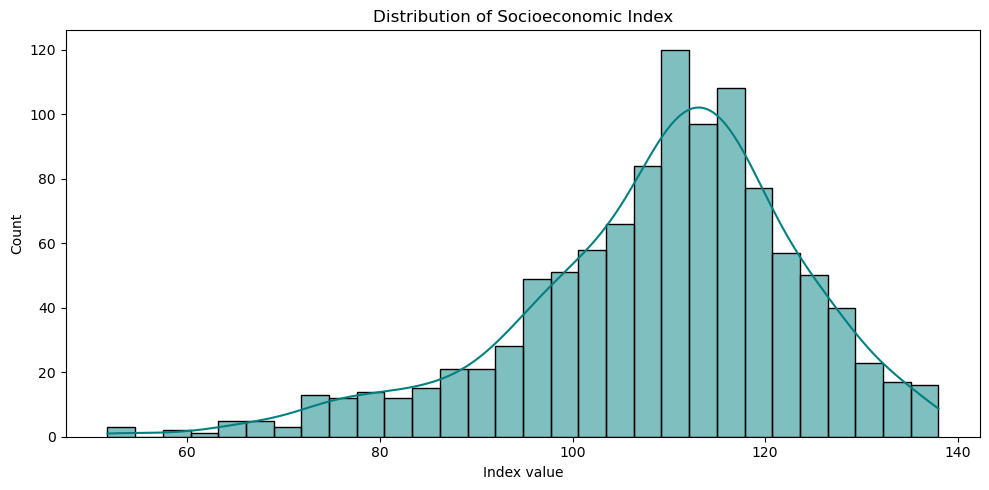

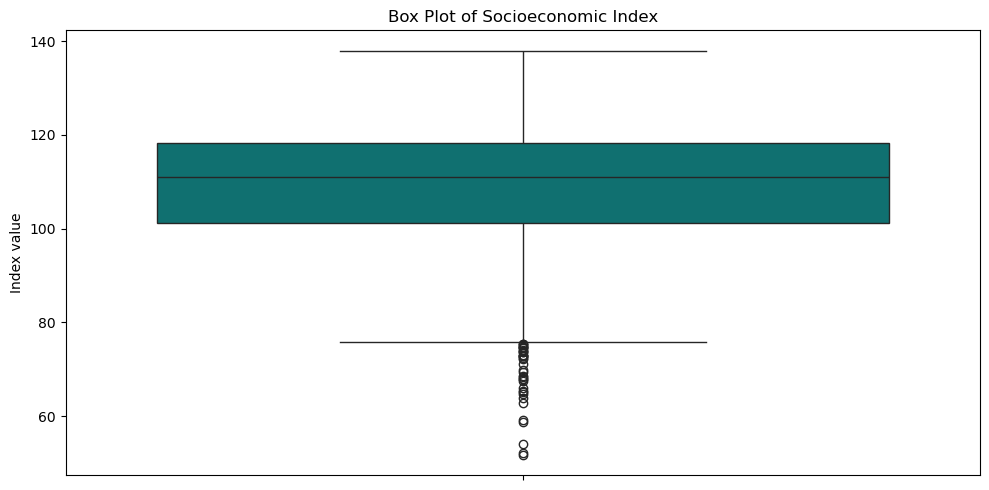


Top 10 census sections by socio-economic index:
      any SECCIO_CENSAL  valor
821  2022   08019305046  138.0
801  2022   08019305026  137.8
797  2022   08019305022  137.4
810  2022   08019305035  137.3
792  2022   08019305017  136.9
823  2022   08019305048  136.8
799  2022   08019305024  136.6
802  2022   08019305027  136.5
805  2022   08019305030  136.4
794  2022   08019305019  136.2

Bottom 10 census sections by socio-economic index:
       any SECCIO_CENSAL  valor
399   2022   08019301026   51.7
1384  2022   08019310089   52.1
1378  2022   08019310083   54.0
1193  2022   08019308110   58.7
382   2022   08019301008   59.1
1377  2022   08019310082   62.7
1201  2022   08019309001   63.9
1118  2022   08019308035   64.6
1194  2022   08019308111   65.1
1213  2022   08019309014   65.4


In [20]:
# Load socioeconomic data if not already loaded
if 'df_socio_bcn' not in globals():
    df_socio_bcn = pd.read_parquet("clean/socio_clean.parquet")

# Ensure 'valor' column is numeric
if df_socio_bcn['valor'].dtype == object:
    df_socio_bcn['valor'] = pd.to_numeric(df_socio_bcn['valor'], errors='coerce')

print("Available columns in socioeconomic data:")
print(df_socio_bcn.columns.tolist())
print(f"\nData shape: {df_socio_bcn.shape}")
print(f"\nSample data:")
print(df_socio_bcn.head())

print("\nDescriptive statistics for socio-economic index (valor):")
print(df_socio_bcn['valor'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df_socio_bcn['valor'], bins=30, color='teal', kde=True)
plt.title("Distribution of Socioeconomic Index")
plt.xlabel("Index value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Box plot for better understanding of distribution
plt.figure(figsize=(10, 5))
sns.boxplot(y=df_socio_bcn['valor'], color='teal')
plt.title("Box Plot of Socioeconomic Index")
plt.ylabel("Index value")
plt.tight_layout()
plt.show()

# Top/bottom census sections by socio-economic index
top_sections = df_socio_bcn.sort_values('valor', ascending=False).head(10)
bottom_sections = df_socio_bcn.sort_values('valor').head(10)

print("\nTop 10 census sections by socio-economic index:")
print(top_sections[['any', 'SECCIO_CENSAL', 'valor']])

print("\nBottom 10 census sections by socio-economic index:")
print(bottom_sections[['any', 'SECCIO_CENSAL', 'valor']])


### 5.2 Consumption Data Analysis

Analyze the distribution of daily water consumption across census sections.

CONSUMPTION DATA ANALYSIS
--------------------------------------------------------------------------------
Found 18 cleaned consumption files
Processing file 5/18: consum_clean_bcn_part_005.parquet
Processing file 10/18: consum_clean_bcn_part_010.parquet
Processing file 15/18: consum_clean_bcn_part_015.parquet
Processing file 18/18: consum_clean_bcn_part_018.parquet

✓ Processed 10,068,280 rows from 18 files
✓ Aggregated to 903,434 section-date combinations
Date range: 2021-01-01 00:00:00 to 2024-12-31 00:00:00
Unique census sections: 621
Unique dates: 1,458

Consumption statistics (daily per census section):
count    903434.000000
mean       4157.923626
std       10261.958115
min           0.000000
25%         605.000000
50%        1665.000000
75%        3863.000000
max      668341.000000
Name: CONSUMO_REAL, dtype: float64


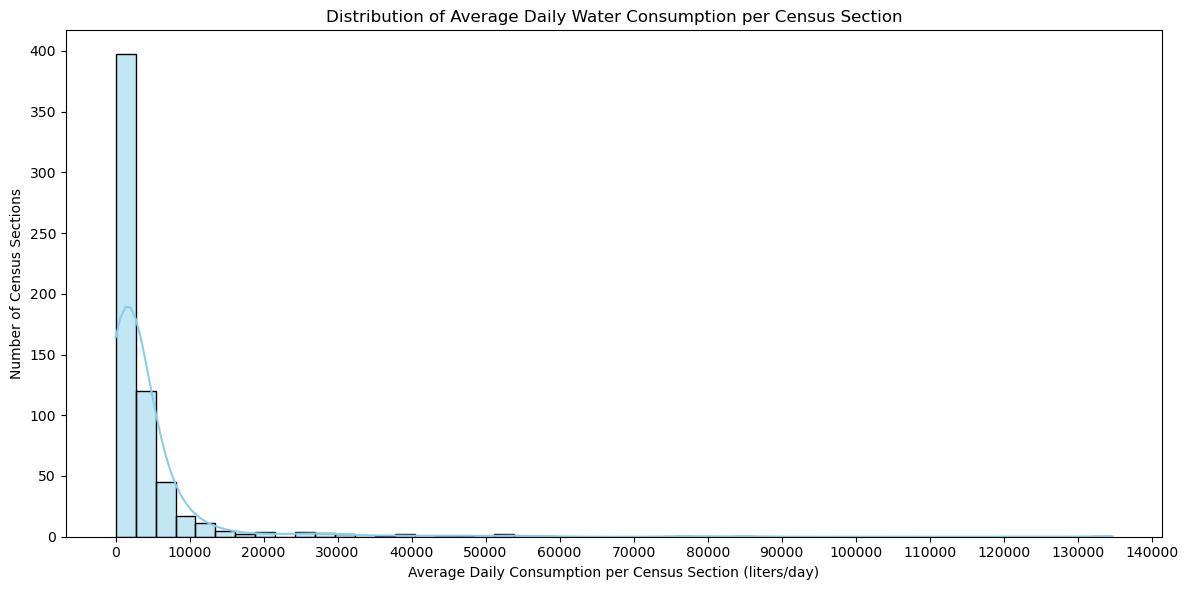


Average consumption per section statistics:
count       621.000000
mean       4156.231460
std        9477.885534
min          29.815808
25%         642.448797
50%        1775.822115
75%        4011.872852
max      134650.167582
Name: avg_consumption, dtype: float64


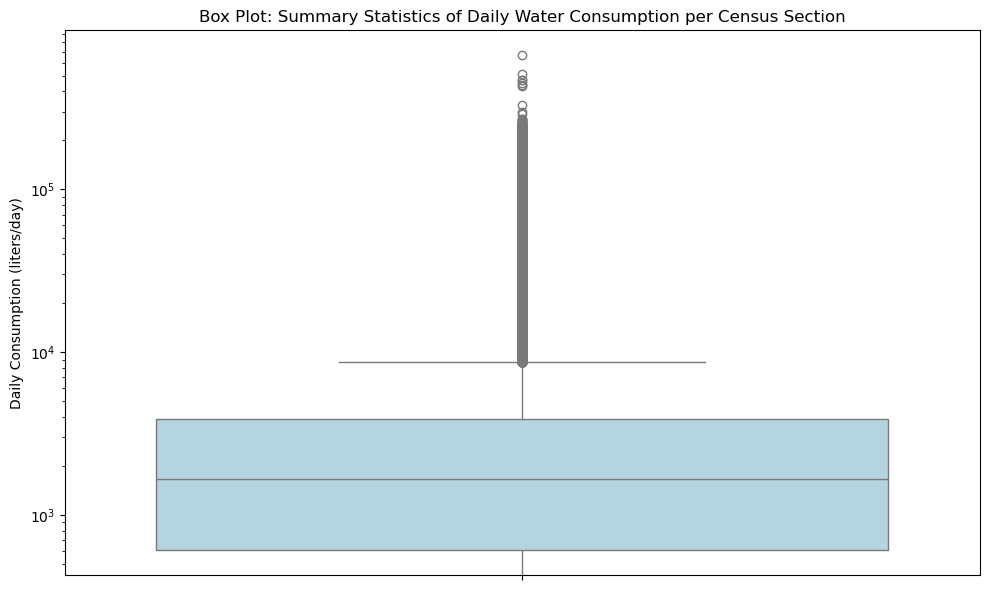


Total consumption by month:
   month_name        sum         mean  count
0     January  302644570  4027.313701  75148
1    February  287079396  4091.081856  70172
2       March  315952148  4105.620718  76956
3       April  306930514  4118.988056  74516
4         May  331049990  4299.629716  76995
5        June  323527181  4341.714276  74516
6        July  329104138  4379.937689  75139
7      August  287433671  3732.856340  77001
8   September  320336428  4298.779194  74518
9     October  335228734  4354.015742  76993
10   November  317792275  4266.641717  74483
11   December  299330528  3887.560918  76997


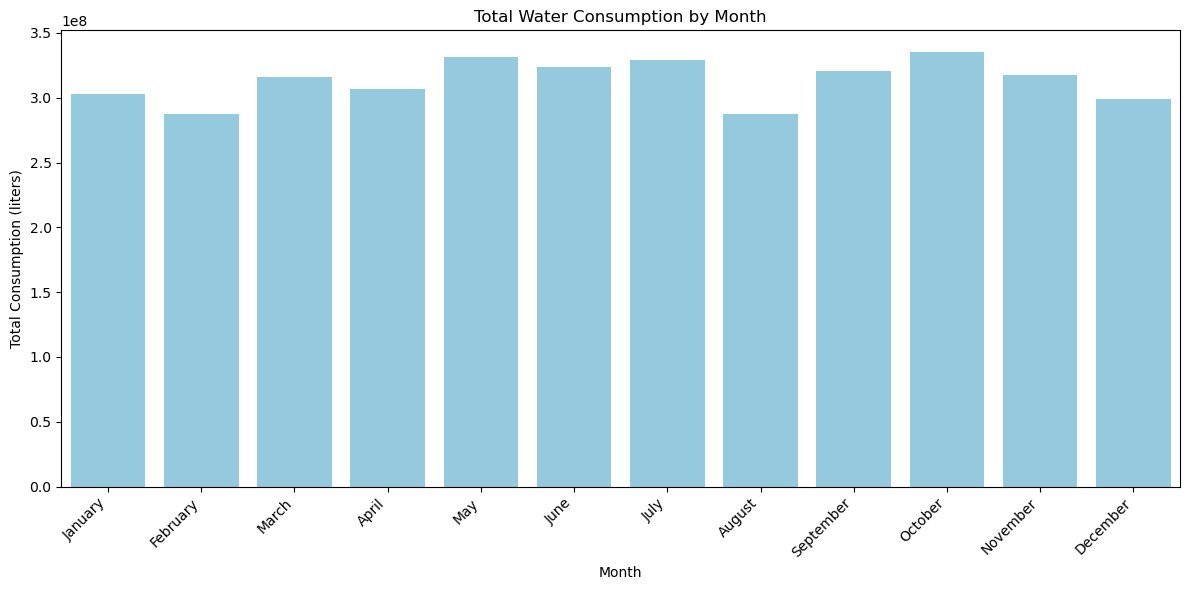

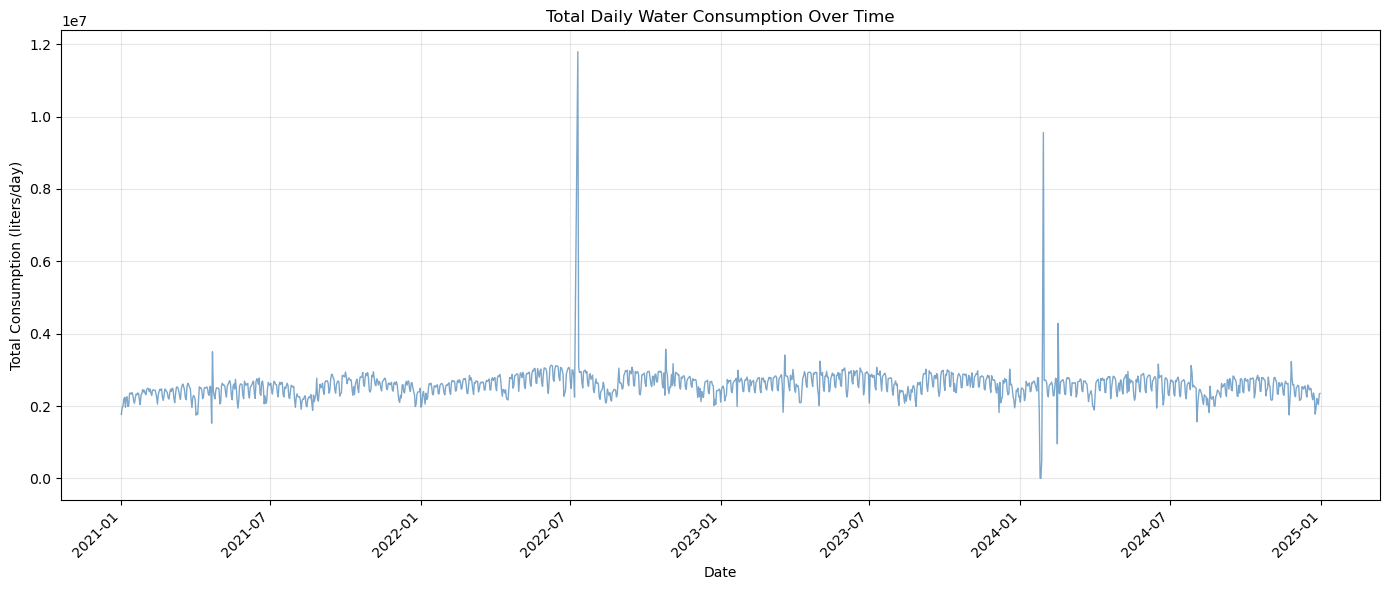

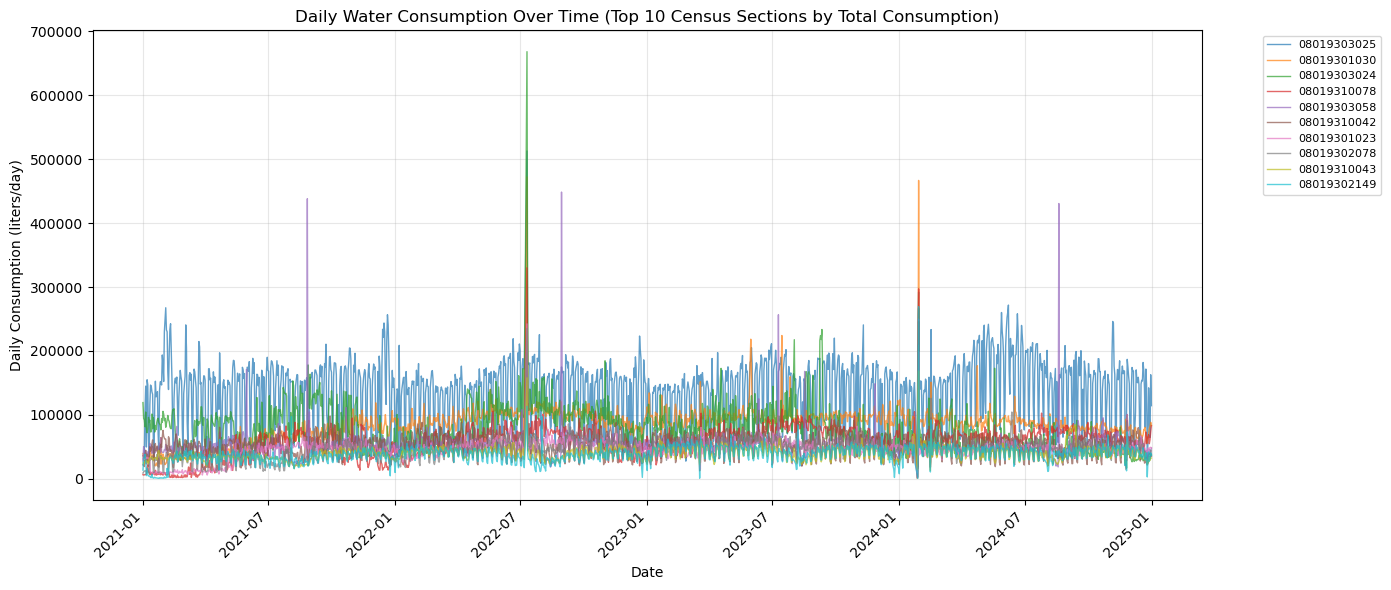

In [21]:
# Load and aggregate consumption data from cleaned split files
# Aggregate by SECCIO_CENSAL and FECHA (sum CONSUMO_REAL per section per day)
import glob
from pathlib import Path

print("CONSUMPTION DATA ANALYSIS")
print("-" * 80)

consum_dir = Path("clean/split_consum_bcn")
consum_files = sorted(glob.glob(str(consum_dir / "consum_clean_bcn_part_*.parquet")))

print(f"Found {len(consum_files)} cleaned consumption files")

# Process all files and aggregate
consum_agg_list = []
total_rows = 0

for i, file_path in enumerate(consum_files, 1):
    if i % 5 == 0 or i == len(consum_files):
        print(f"Processing file {i}/{len(consum_files)}: {Path(file_path).name}")
    
    df_chunk = pd.read_parquet(file_path)
    df_chunk['FECHA'] = pd.to_datetime(df_chunk['FECHA'], errors='coerce')
    total_rows += len(df_chunk)
    
    # Aggregate: sum CONSUMO_REAL by SECCIO_CENSAL and FECHA
    df_chunk_agg = (
        df_chunk
        .groupby(['SECCIO_CENSAL', 'FECHA'])
        .agg({'CONSUMO_REAL': 'sum'})
        .reset_index()
    )
    
    consum_agg_list.append(df_chunk_agg)

# Combine all aggregated chunks
df_consum_agg = pd.concat(consum_agg_list, ignore_index=True)

# Final aggregation (in case same SECCIO_CENSAL + FECHA appears in multiple files)
df_consum_agg = (
    df_consum_agg
    .groupby(['SECCIO_CENSAL', 'FECHA'])
    .agg({'CONSUMO_REAL': 'sum'})
    .reset_index()
)

print(f"\n✓ Processed {total_rows:,} rows from {len(consum_files)} files")
print(f"✓ Aggregated to {len(df_consum_agg):,} section-date combinations")
print(f"Date range: {df_consum_agg['FECHA'].min()} to {df_consum_agg['FECHA'].max()}")
print(f"Unique census sections: {df_consum_agg['SECCIO_CENSAL'].nunique():,}")
print(f"Unique dates: {df_consum_agg['FECHA'].nunique():,}")

print(f"\nConsumption statistics (daily per census section):")
print(df_consum_agg['CONSUMO_REAL'].describe())

# 1. Distribution plot: Histogram of average consumption per census section
avg_consumption_per_section = (
    df_consum_agg
    .groupby('SECCIO_CENSAL')['CONSUMO_REAL']
    .mean()
    .reset_index(name='avg_consumption')
)

# Get data range for axis limits
data_min = avg_consumption_per_section['avg_consumption'].min()
data_max = avg_consumption_per_section['avg_consumption'].max()
data_range = data_max - data_min
# Add 5% padding on each side
x_min = data_min - (data_range * 0.05)
x_max = data_max + (data_range * 0.05)

plt.figure(figsize=(12, 6))
sns.histplot(avg_consumption_per_section['avg_consumption'], bins=50, color='skyblue', kde=True)
plt.title("Distribution of Average Daily Water Consumption per Census Section")
plt.xlabel("Average Daily Consumption per Census Section (liters/day)")
plt.ylabel("Number of Census Sections")
plt.xlim(x_min, x_max)
plt.locator_params(axis='x', nbins=15)
plt.tight_layout()
plt.show()

print(f"\nAverage consumption per section statistics:")
print(avg_consumption_per_section['avg_consumption'].describe())

# 2. Box plot: Summary statistics
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_consum_agg['CONSUMO_REAL'], color='lightblue')
plt.yscale('log')
plt.title("Box Plot: Summary Statistics of Daily Water Consumption per Census Section")
plt.ylabel("Daily Consumption (liters/day)")
plt.tight_layout()
plt.show()

# 3. Consumption by month
df_consum_agg['month'] = df_consum_agg['FECHA'].dt.month
df_consum_agg['month_name'] = df_consum_agg['FECHA'].dt.strftime('%B')

consumption_by_month = (
    df_consum_agg
    .groupby('month')['CONSUMO_REAL']
    .agg(['sum', 'mean', 'count'])
    .reset_index()
)
consumption_by_month['month_name'] = pd.to_datetime(consumption_by_month['month'], format='%m').dt.strftime('%B')
consumption_by_month = consumption_by_month.sort_values('month')

print("\nTotal consumption by month:")
print(consumption_by_month[['month_name', 'sum', 'mean', 'count']])

# Plot total consumption by month
plt.figure(figsize=(12, 6))
sns.barplot(data=consumption_by_month, x='month_name', y='sum', color='skyblue', order=consumption_by_month['month_name'])
plt.title("Total Water Consumption by Month")
plt.xlabel("Month")
plt.ylabel("Total Consumption (liters)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Consumption over time (daily aggregate)
consumption_daily = (
    df_consum_agg
    .groupby('FECHA')['CONSUMO_REAL']
    .agg(['sum', 'mean'])
    .reset_index()
    .sort_values('FECHA')
)

plt.figure(figsize=(14, 6))
plt.plot(consumption_daily['FECHA'], consumption_daily['sum'], color='steelblue', linewidth=1, alpha=0.7)
plt.title("Total Daily Water Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Total Consumption (liters/day)")
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Average consumption per census section over time (top 10 sections by total consumption)
section_totals = (
    df_consum_agg
    .groupby('SECCIO_CENSAL')['CONSUMO_REAL']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

top_sections = section_totals.index.tolist()
df_top_sections = df_consum_agg[df_consum_agg['SECCIO_CENSAL'].isin(top_sections)]

plt.figure(figsize=(14, 6))
for section in top_sections:
    section_data = df_top_sections[df_top_sections['SECCIO_CENSAL'] == section].sort_values('FECHA')
    plt.plot(section_data['FECHA'], section_data['CONSUMO_REAL'], label=section, linewidth=1, alpha=0.7)

plt.title("Daily Water Consumption Over Time (Top 10 Census Sections by Total Consumption)")
plt.xlabel("Date")
plt.ylabel("Daily Consumption (liters/day)")
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 5.3 Leak Incidents Analysis

Analyze temporal patterns in leak incidents across Barcelona. Since the cleaned data has one leak per row (one leak per POLISSA_SUBM per day), we can analyze the data directly without additional aggregation steps. The analysis includes:

- Distribution of leaks per census section-date
- Temporal trends (daily, monthly)
- Analysis by use type (US_AIGUA_SUBM) 

LEAK INCIDENTS ANALYSIS

Loading cleaned leak data from: clean/fuites_clean_bcn.parquet
--------------------------------------------------------------------------------

✓ Loaded 1,359 leaks from single file
Date range: 2023-01-04 00:00:00 to 2025-05-27 00:00:00
Unique census sections: 436
Unique dates: 505
Unique POLISSA_SUBM: 690

Leak statistics (number of leaks per section-date):
count    1351.000000
mean        1.005922
std         0.076752
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: num_fuites, dtype: float64

Leak statistics per POLISSA_SUBM:
count    690.000000
mean       1.969565
std        2.098573
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       22.000000
Name: num_leaks, dtype: float64


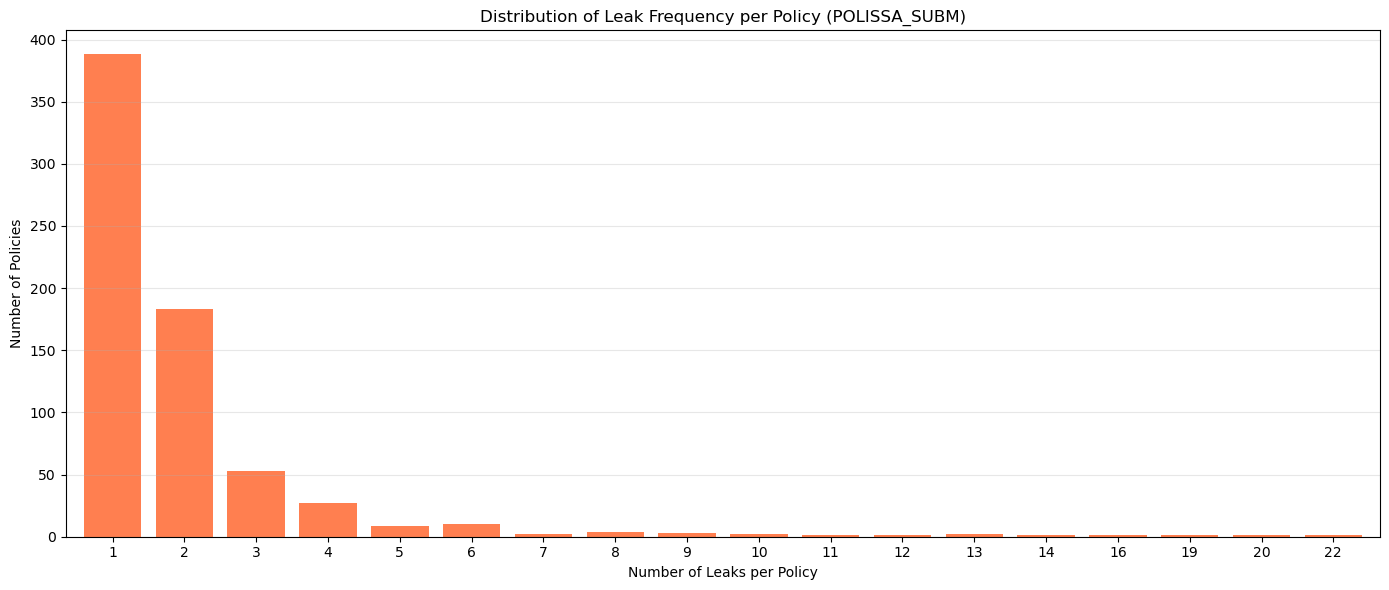


Leak statistics per SECCIO_CENSAL:
count    436.000000
mean       3.116972
std        3.622102
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       27.000000
Name: num_leaks, dtype: float64


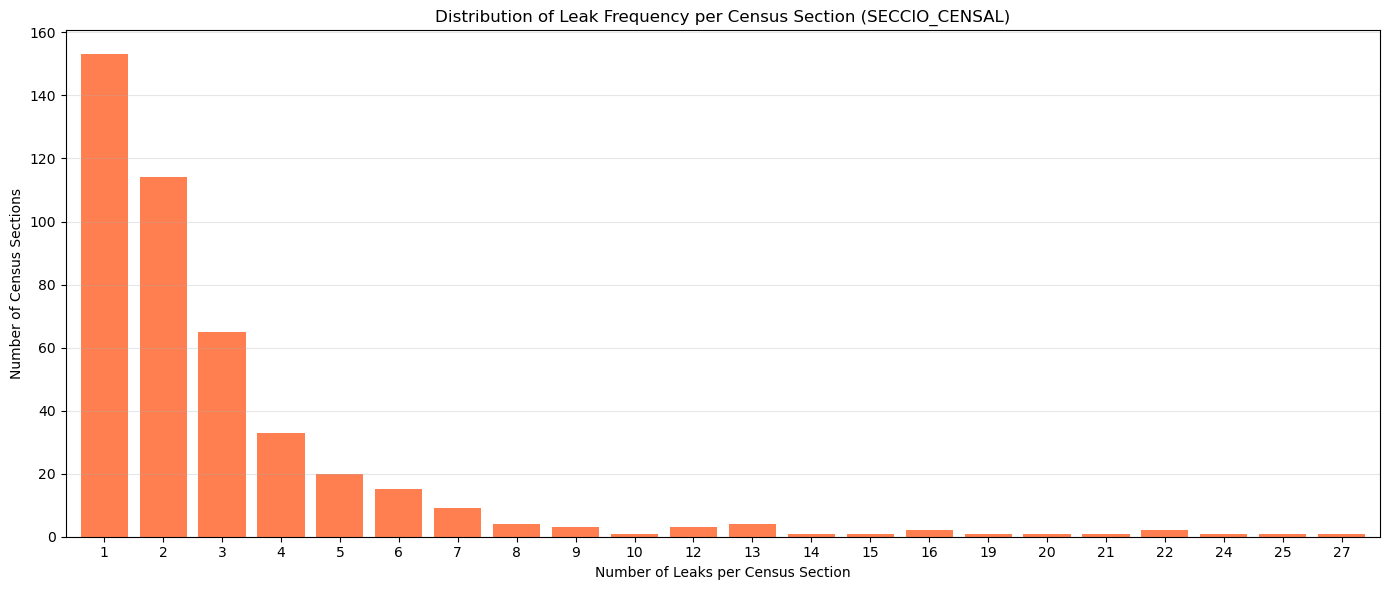


Top 10 census sections by number of leaks:
    SECCIO_CENSAL  num_leaks
13    08019301020         27
274   08019306024         25
206   08019305002         24
218   08019305027         22
139   08019303025         22
132   08019303013         21
205   08019305001         20
89    08019302094         19
225   08019305038         16
90    08019302095         16

Top 10 policies by number of leaks:
         POLISSA_SUBM  num_leaks
26   3TBFYGVTVTN6G7F2         22
242  FRSID5U4SBQLHF7H         20
516  SJA7U434O4MBU2O3         19
458  PUPJA5U67MNHDCVR         16
607  WIBBSXJZ45VTZ7YF         14
548  TRLVNHZWFS7JSMAV         13
466  QEPJ3GL36LPH6JMU         13
597  W2BYTBNOF6ZLOIW3         12
256  GMBUHODHUYE4MBSM         11
113  A4KLSP3WFS7DRPRG         10


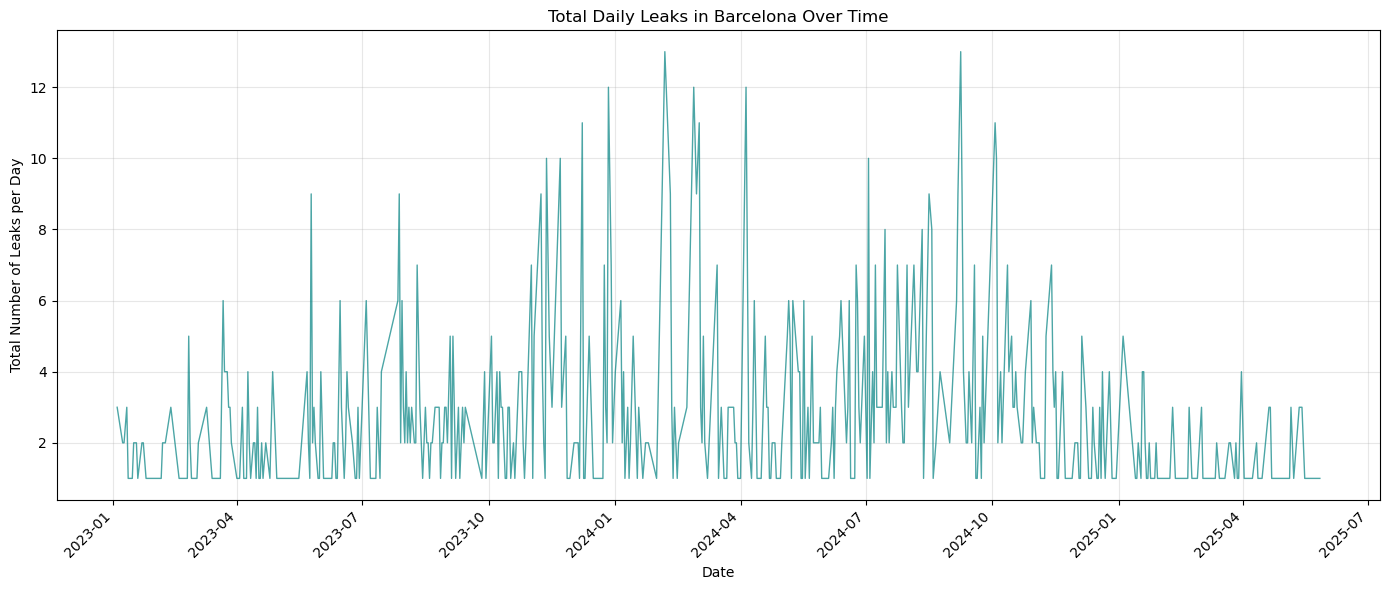


Filtering to full years only (2023 and 2024):
  Total leaks in dataset: 1,359
  Leaks in 2023-2024: 1,243
  Leaks excluded (partial years): 116

Total leaks by month (2023-2024 only, full years):
   month_name  total_leaks      mean  count
0     January           65  1.015625     64
1    February           85  1.000000     85
2       March           88  1.011494     87
3       April           88  1.000000     88
4         May           90  1.011236     89
5        June          110  1.009174    109
6        July          129  1.015748    127
7      August          121  1.000000    121
8   September          115  1.000000    115
9     October          138  1.000000    138
10   November          113  1.008929    112
11   December          101  1.010000    100


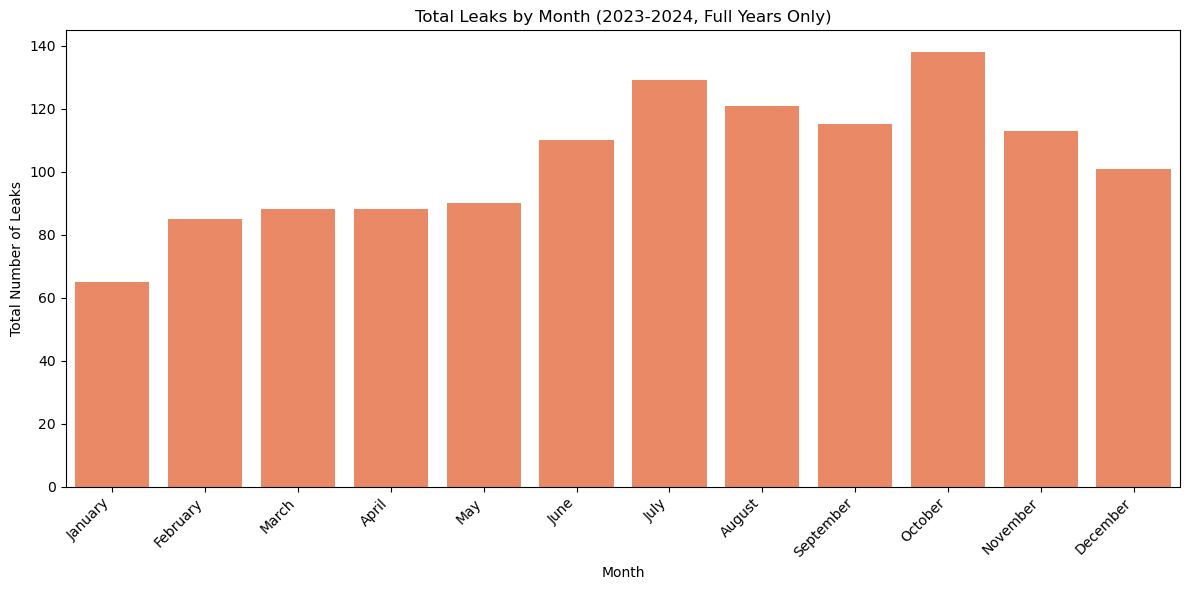


Leaks by use type:
  US_AIGUA_SUBM  num_leaks
2      DOMÈSTIC        976
3    INDUSTRIAL        172
0     COMERCIAL        168
1    COMUNITARI         43


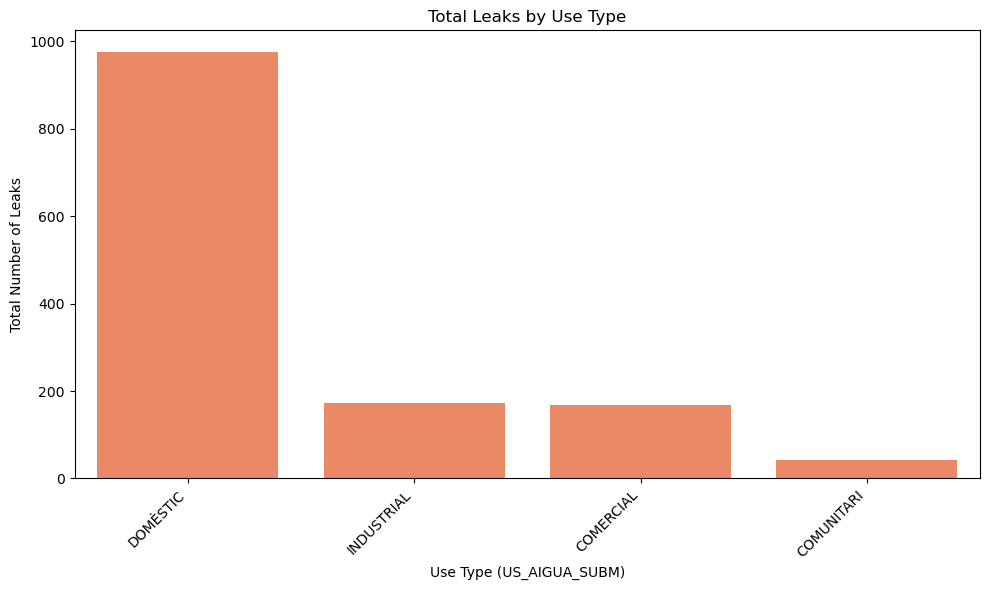

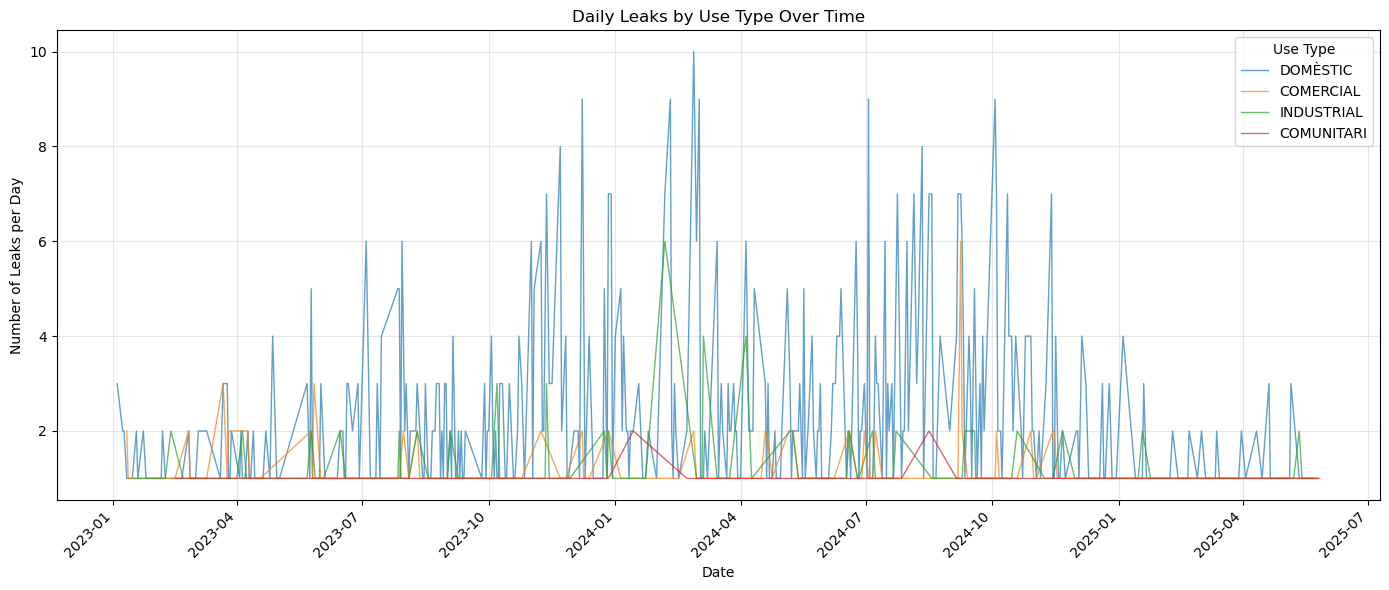

In [22]:
# Load leak incidents data from cleaned single parquet file
# Since we have one leak per row (one leak per POLISSA_SUBM per day), we can work directly with the data
from pathlib import Path

print("=" * 80)
print("LEAK INCIDENTS ANALYSIS")
print("=" * 80)

# Load single cleaned parquet file
fuites_file = Path("clean/fuites_clean_bcn.parquet")

if fuites_file.exists():
    print(f"\nLoading cleaned leak data from: {fuites_file}")
    print("-" * 80)
    
    df_fuites = pd.read_parquet(fuites_file)
    # CREATED_MENSAJE is already a date (from cleaning step), convert to datetime for analysis
    df_fuites['FECHA'] = pd.to_datetime(df_fuites['CREATED_MENSAJE'])
else:
    print(f"\n⚠ Error: File not found: {fuites_file}")
    print("Please run the cleaning step first (Section 3.2)")
    df_fuites = pd.DataFrame()

if len(df_fuites) > 0:
    print(f"\n✓ Loaded {len(df_fuites):,} leaks from single file")
    print(f"Date range: {df_fuites['FECHA'].min()} to {df_fuites['FECHA'].max()}")
    print(f"Unique census sections: {df_fuites['SECCIO_CENSAL'].nunique():,}")
    print(f"Unique dates: {df_fuites['FECHA'].nunique():,}")
    print(f"Unique POLISSA_SUBM: {df_fuites['POLISSA_SUBM'].nunique():,}")
else:
    print(f"\n⚠ No data loaded - cannot continue analysis")

# Aggregate by section-date for analysis
df_fuites_agg = (
    df_fuites
    .groupby(['SECCIO_CENSAL', 'FECHA'])
    .size()
    .reset_index(name='num_fuites')
)

print(f"\nLeak statistics (number of leaks per section-date):")
print(df_fuites_agg['num_fuites'].describe())

# 1. Distribution of leaks per POLISSA_SUBM (how many leaks does each policy have?)
leaks_per_polissa = (
    df_fuites
    .groupby('POLISSA_SUBM')
    .size()
    .reset_index(name='num_leaks')
    .sort_values('num_leaks', ascending=False)
)

print(f"\nLeak statistics per POLISSA_SUBM:")
print(leaks_per_polissa['num_leaks'].describe())

# Count how many policies have each number of leaks
leak_counts_polissa = leaks_per_polissa['num_leaks'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
leak_counts_polissa.plot(kind='bar', color='coral', width=0.8)
plt.title("Distribution of Leak Frequency per Policy (POLISSA_SUBM)")
plt.xlabel("Number of Leaks per Policy")
plt.ylabel("Number of Policies")
plt.xticks(rotation=0, ha='center')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 2. Distribution of leaks per SECCIO_CENSAL (how many leaks per census section?)
leaks_per_section = (
    df_fuites
    .groupby('SECCIO_CENSAL')
    .size()
    .reset_index(name='num_leaks')
    .sort_values('num_leaks', ascending=False)
)

print(f"\nLeak statistics per SECCIO_CENSAL:")
print(leaks_per_section['num_leaks'].describe())

# Count how many sections have each number of leaks
leak_counts_section = leaks_per_section['num_leaks'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
leak_counts_section.plot(kind='bar', color='coral', width=0.8)
plt.title("Distribution of Leak Frequency per Census Section (SECCIO_CENSAL)")
plt.xlabel("Number of Leaks per Census Section")
plt.ylabel("Number of Census Sections")
plt.xticks(rotation=0, ha='center')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Additional: Top sections and policies by leak count
print(f"\nTop 10 census sections by number of leaks:")
print(leaks_per_section.head(10))

print(f"\nTop 10 policies by number of leaks:")
print(leaks_per_polissa.head(10))

# 3. Leaks over time (daily aggregate)
leaks_daily = (
    df_fuites
    .groupby('FECHA')
    .size()
    .reset_index(name='num_fuites')
    .sort_values('FECHA')
)

plt.figure(figsize=(14, 6))
plt.plot(leaks_daily['FECHA'], leaks_daily['num_fuites'], color='teal', linewidth=1, alpha=0.7)
plt.title("Total Daily Leaks in Barcelona Over Time")
plt.xlabel("Date")
plt.ylabel("Total Number of Leaks per Day")
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Leaks by month (only full years: 2023 and 2024)
# Filter to only include full years to avoid partial year bias
df_fuites['year'] = df_fuites['FECHA'].dt.year
df_fuites_full_years = df_fuites[df_fuites['year'].isin([2023, 2024])].copy()

print(f"\nFiltering to full years only (2023 and 2024):")
print(f"  Total leaks in dataset: {len(df_fuites):,}")
print(f"  Leaks in 2023-2024: {len(df_fuites_full_years):,}")
print(f"  Leaks excluded (partial years): {len(df_fuites) - len(df_fuites_full_years):,}")

df_fuites_full_years['month'] = df_fuites_full_years['FECHA'].dt.month
df_fuites_full_years['month_name'] = df_fuites_full_years['FECHA'].dt.strftime('%B')

leaks_by_month = (
    df_fuites_full_years
    .groupby('month')
    .size()
    .reset_index(name='total_leaks')
)
leaks_by_month['month_name'] = pd.to_datetime(leaks_by_month['month'], format='%m').dt.strftime('%B')
leaks_by_month = leaks_by_month.sort_values('month')

# Also calculate mean leaks per section-date by month (using full years only)
df_fuites_agg_full_years = df_fuites_agg[df_fuites_agg['FECHA'].dt.year.isin([2023, 2024])].copy()
leaks_by_month_agg = (
    df_fuites_agg_full_years
    .assign(month=df_fuites_agg_full_years['FECHA'].dt.month)
    .groupby('month')['num_fuites']
    .agg(['mean', 'count'])
    .reset_index()
)
leaks_by_month = leaks_by_month.merge(leaks_by_month_agg, on='month', how='left')
leaks_by_month = leaks_by_month.sort_values('month')

print("\nTotal leaks by month (2023-2024 only, full years):")
print(leaks_by_month[['month_name', 'total_leaks', 'mean', 'count']])

plt.figure(figsize=(12, 6))
sns.barplot(data=leaks_by_month, x='month_name', y='total_leaks', color='coral', order=leaks_by_month['month_name'])
plt.title("Total Leaks by Month (2023-2024, Full Years Only)")
plt.xlabel("Month")
plt.ylabel("Total Number of Leaks")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Leaks by use type (US_AIGUA_SUBM)
if 'US_AIGUA_SUBM' in df_fuites.columns:
    leaks_by_use = (
        df_fuites
        .groupby('US_AIGUA_SUBM')
        .size()
        .reset_index(name='num_leaks')
        .sort_values('num_leaks', ascending=False)
    )
    
    print("\nLeaks by use type:")
    print(leaks_by_use)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=leaks_by_use, x='US_AIGUA_SUBM', y='num_leaks', color='coral')
    plt.title("Total Leaks by Use Type")
    plt.xlabel("Use Type (US_AIGUA_SUBM)")
    plt.ylabel("Total Number of Leaks")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Leaks by use type over time
    leaks_by_use_time = (
        df_fuites
        .groupby(['FECHA', 'US_AIGUA_SUBM'])
        .size()
        .reset_index(name='num_leaks')
        .sort_values('FECHA')
    )
    
    plt.figure(figsize=(14, 6))
    for use_type in leaks_by_use_time['US_AIGUA_SUBM'].unique():
        use_data = leaks_by_use_time[leaks_by_use_time['US_AIGUA_SUBM'] == use_type]
        plt.plot(use_data['FECHA'], use_data['num_leaks'], label=use_type, linewidth=1, alpha=0.7)
    plt.title("Daily Leaks by Use Type Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Leaks per Day")
    plt.legend(title='Use Type')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠ US_AIGUA_SUBM column not found in data")


### 5.4 Consumption Patterns: Weekday vs. Weekend by Type of Use

Analyze differences in consumption patterns between weekdays and weekends, broken down by water use type.

Loading all consumption data for weekday/weekend analysis...
Found 18 consumption files to load
--------------------------------------------------------------------------------
Loading file 1/18: consum_clean_bcn_part_001.parquet
Loading file 2/18: consum_clean_bcn_part_002.parquet
Loading file 3/18: consum_clean_bcn_part_003.parquet
Loading file 4/18: consum_clean_bcn_part_004.parquet
Loading file 5/18: consum_clean_bcn_part_005.parquet
Loading file 6/18: consum_clean_bcn_part_006.parquet
Loading file 7/18: consum_clean_bcn_part_007.parquet
Loading file 8/18: consum_clean_bcn_part_008.parquet
Loading file 9/18: consum_clean_bcn_part_009.parquet
Loading file 10/18: consum_clean_bcn_part_010.parquet
Loading file 11/18: consum_clean_bcn_part_011.parquet
Loading file 12/18: consum_clean_bcn_part_012.parquet
Loading file 13/18: consum_clean_bcn_part_013.parquet
Loading file 14/18: consum_clean_bcn_part_014.parquet
Loading file 15/18: consum_clean_bcn_part_015.parquet
Loading file 16/18: co

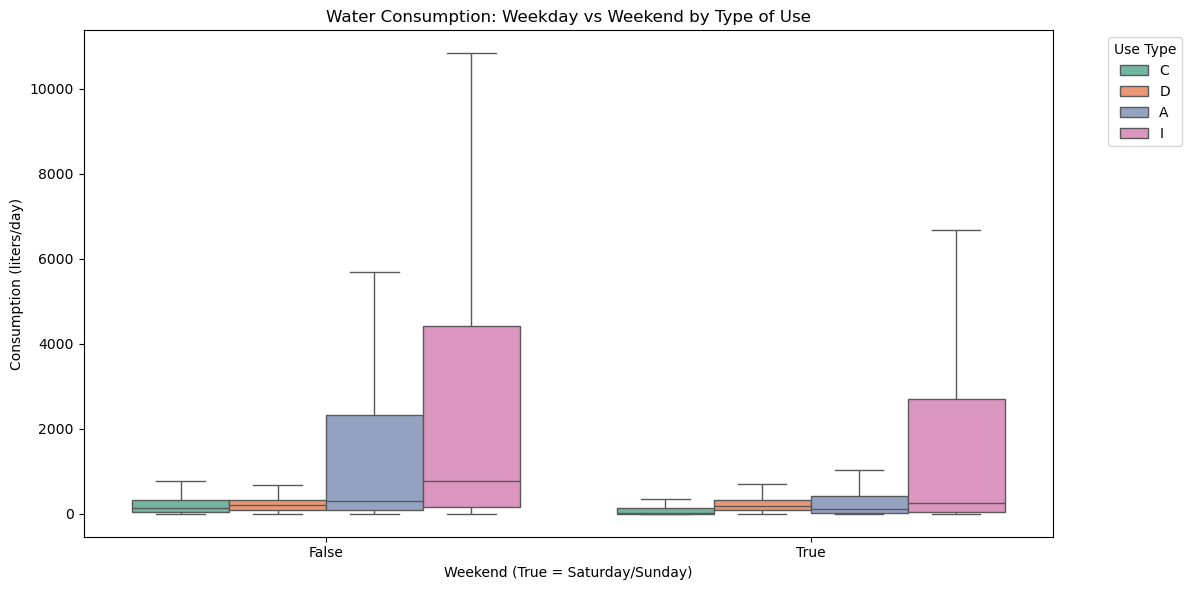


Summary statistics by weekend and use type:
                              count         mean           std  min    25%  \
is_weekend US_AIGUA_GEST                                                     
False      A                49861.0  2989.909228   7742.647137  0.0   82.0   
           C               887489.0   403.378603   1203.065745  0.0   39.0   
           D              6109531.0   242.315642    313.976738  0.0   96.0   
           I               154923.0  5118.889171  11482.204091  0.0  151.0   
True       A                19754.0  1750.407917   5782.803874  0.0    5.0   
           C               353011.0   275.534969   1110.129292  0.0    0.0   
           D              2432048.0   239.568331    315.390316  0.0   82.0   
           I                61663.0  4238.861667  10999.090657  0.0   31.0   

                            50%     75%       max  
is_weekend US_AIGUA_GEST                           
False      A              300.0  2326.0  425280.0  
           C      

In [23]:
# For this analysis, we need the detailed consumption data (not aggregated)
# Load all files to analyze weekday/weekend patterns
print("Loading all consumption data for weekday/weekend analysis...")

consum_dir = Path("clean/split_consum_bcn")
consum_files = sorted(glob.glob(str(consum_dir / "consum_clean_bcn_part_*.parquet")))

print(f"Found {len(consum_files)} consumption files to load")
print("-" * 80)

# Load all files
consum_list = []
for i, file_path in enumerate(consum_files, 1):
    print(f"Loading file {i}/{len(consum_files)}: {Path(file_path).name}")
    df_chunk = pd.read_parquet(file_path)
    consum_list.append(df_chunk)

# Combine all data
df_consum_sample = pd.concat(consum_list, ignore_index=True)

print(f"\n✓ All data loaded: {len(df_consum_sample):,} rows")
print(f"Date range: {df_consum_sample['FECHA'].min()} to {df_consum_sample['FECHA'].max()}")

# Ensure date is parsed
df_consum_sample['FECHA'] = pd.to_datetime(df_consum_sample['FECHA'], errors='coerce')

# Extract weekday info
df_consum_sample['weekday'] = df_consum_sample['FECHA'].dt.day_name()
df_consum_sample['is_weekend'] = df_consum_sample['FECHA'].dt.dayofweek >= 5  # Saturday=5, Sunday=6

# Check if US_AIGUA_GEST column exists
if 'US_AIGUA_GEST' in df_consum_sample.columns:
    # Plot: Consumption by weekend and by type of use
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_consum_sample,
        x='is_weekend',
        y='CONSUMO_REAL',
        hue='US_AIGUA_GEST',
        showfliers=False,
        palette='Set2'
    )
    # Use linear scale so potential negative or near-zero consumptions are visible
    plt.title("Water Consumption: Weekday vs Weekend by Type of Use")
    plt.xlabel("Weekend (True = Saturday/Sunday)")
    plt.ylabel("Consumption (liters/day)")
    plt.legend(title="Use Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\nSummary statistics by weekend and use type:")
    summary = df_consum_sample.groupby(['is_weekend', 'US_AIGUA_GEST'])['CONSUMO_REAL'].describe()
    print(summary)
else:
    print("⚠ Column 'US_AIGUA_GEST' not found in consumption data")
    print("Available columns:", df_consum_sample.columns.tolist())

### 5.5 Weather Data Analysis

Analyze weather patterns and their relationship with water consumption and leaks. We manually cleaned the columns NOM_VARIABLE and UNITAT of the dataset to remove corrupted characters due to accents.

ROWS WITH INCORRECT NOM_VARIABLE VALUES

Total rows with incorrect NOM_VARIABLE: 0
Total rows in dataset: 129,086
Percentage incorrect: 0.0000%

✓ All rows have correct NOM_VARIABLE values

Weather data shape: (129086, 10)
Date range: 2021-01-01 00:00:00 to 2025-11-16 00:00:00
Available columns: ['ID', 'CODI_ESTACIO', 'NOM_ESTACIO', 'DATA_LECTURA', 'CODI_VARIABLE', 'NOM_VARIABLE', 'VALOR', 'UNITAT', 'HORA _TU', 'VALOR_NUM']

COMPREHENSIVE WEATHER DATA ANALYSIS

Pivoted weather data (all variables): (1779, 25)
Variables: ['Amplitud tèrmica diària', 'Direcció de la ratxa màx. diària de vent 10 m', 'Direcció mitjana diària del vent 10 m (m. 1)', 'Direcció mitjana diària del vent 10 m (m. u)', 'Evapotranspiració de referència', 'Humitat relativa mitjana diària', 'Humitat relativa màxima diària + data', 'Humitat relativa mínima diària + data', 'Irradiació solar global diària', 'Precipitació acumulada diària', 'Precipitació acumulada diària (8-8 h)', 'Precipitació màxima en 1 h (diària) + ho

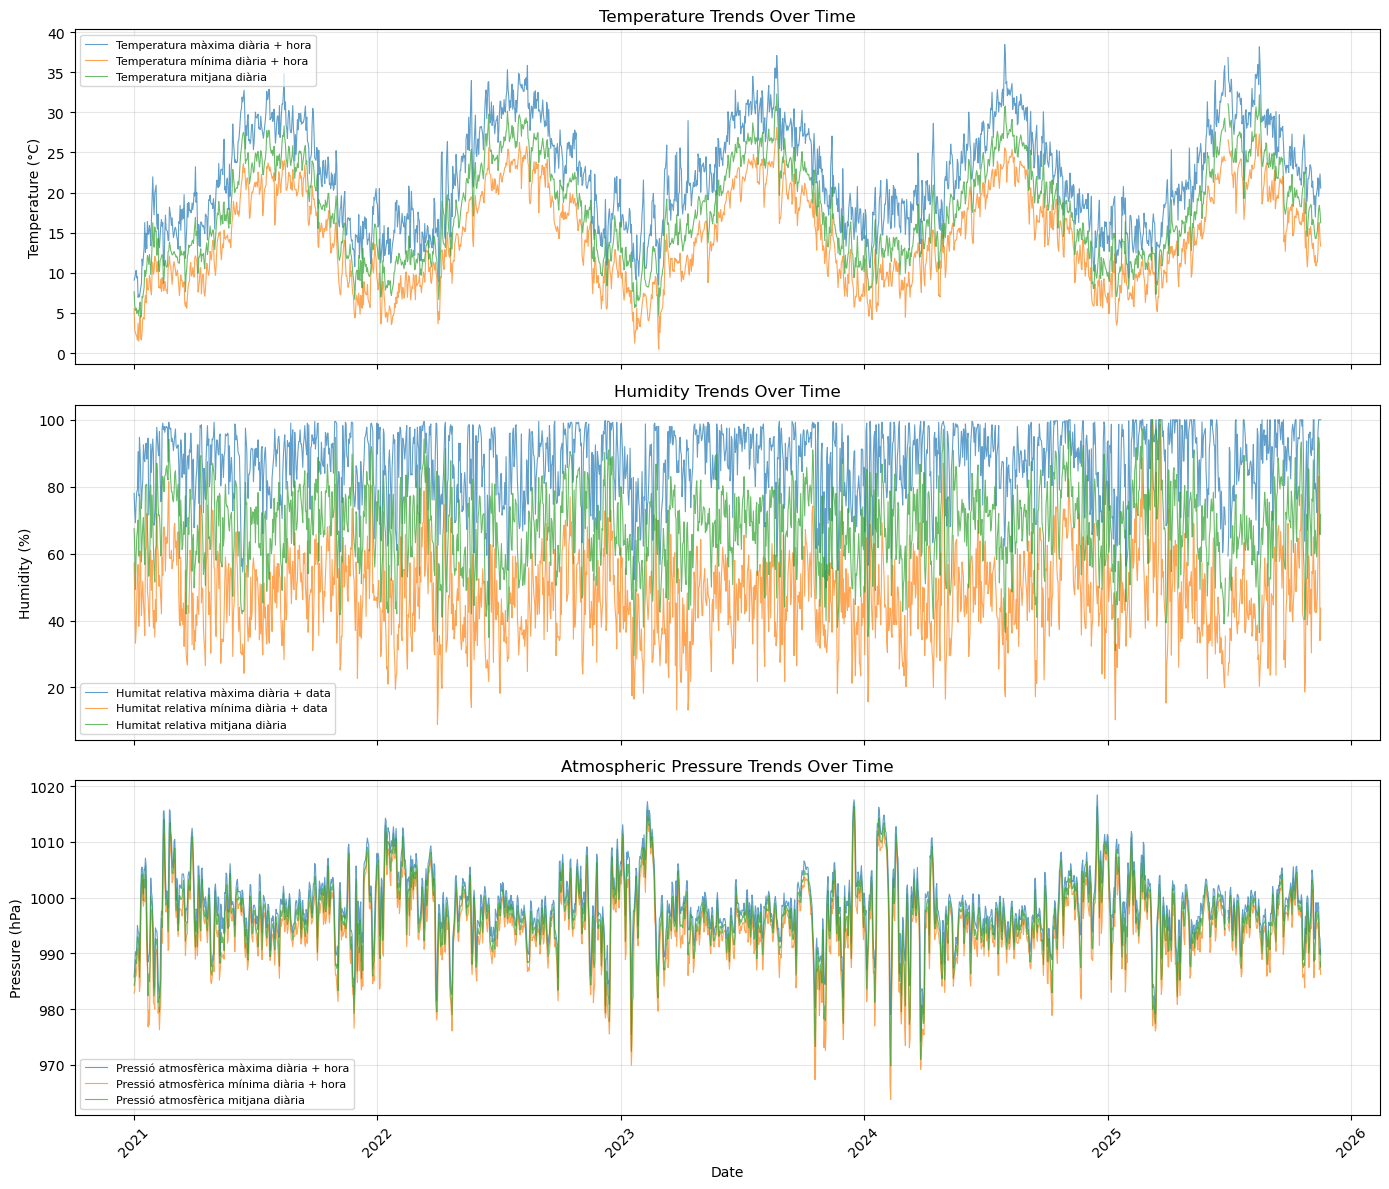

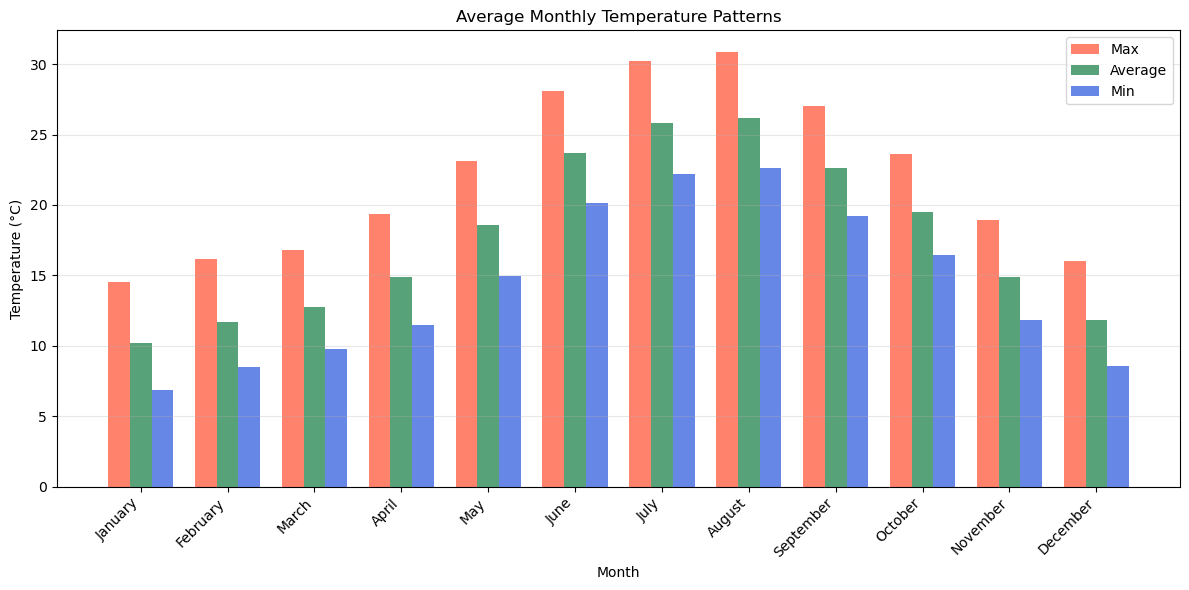

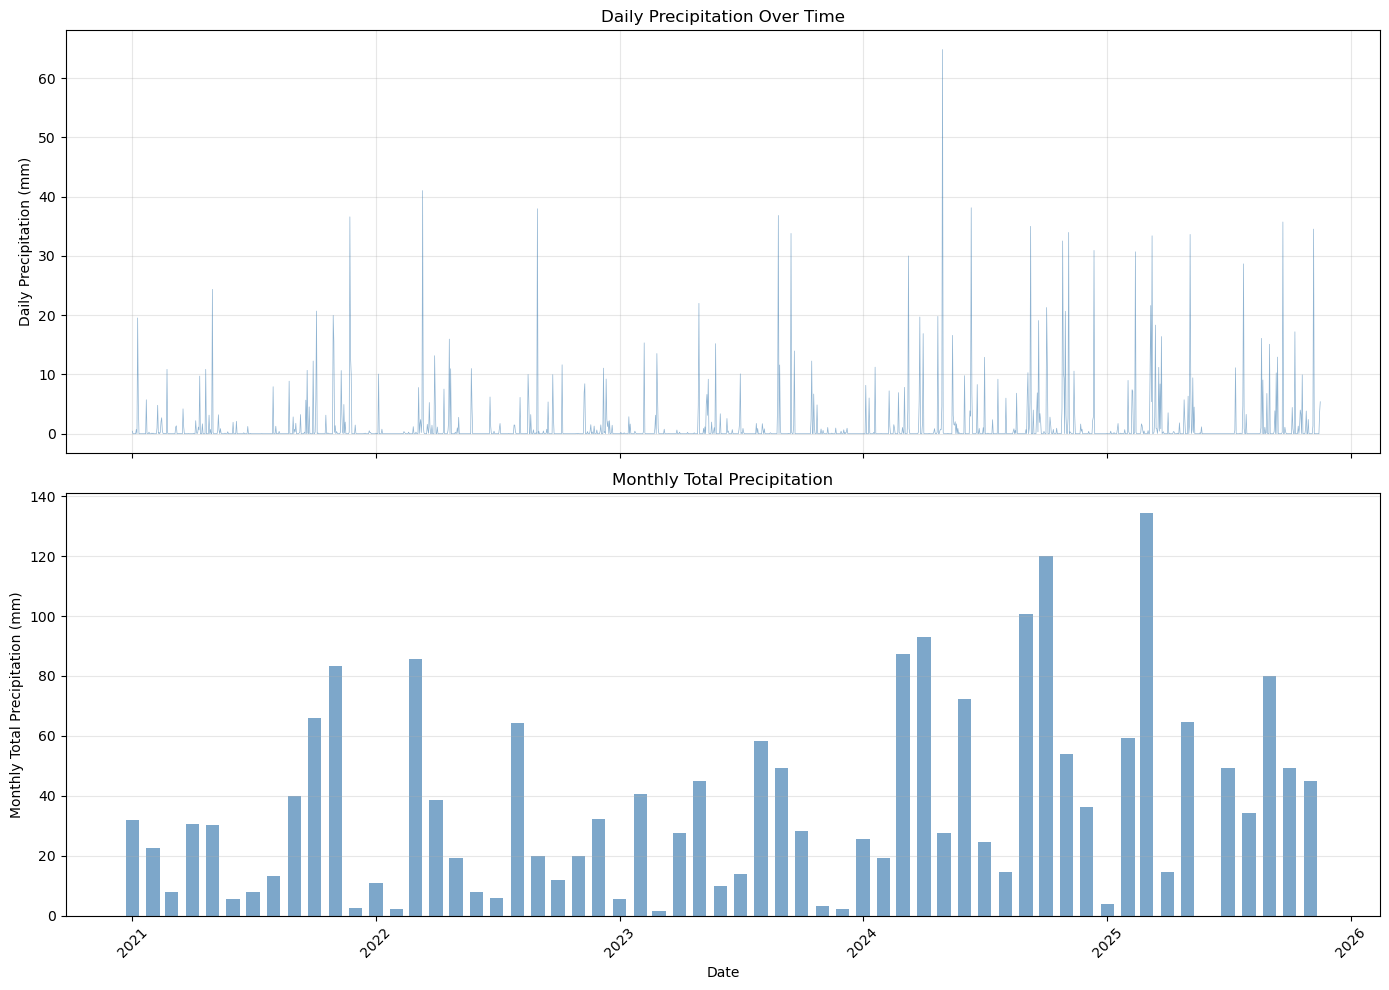


Precipitation statistics:
count    1778.000000
mean        1.213198
std         4.573727
min         0.000000
25%         0.000000
50%         0.000000
75%         0.066667
max        64.833333
Name: Precipitació acumulada diària, dtype: float64


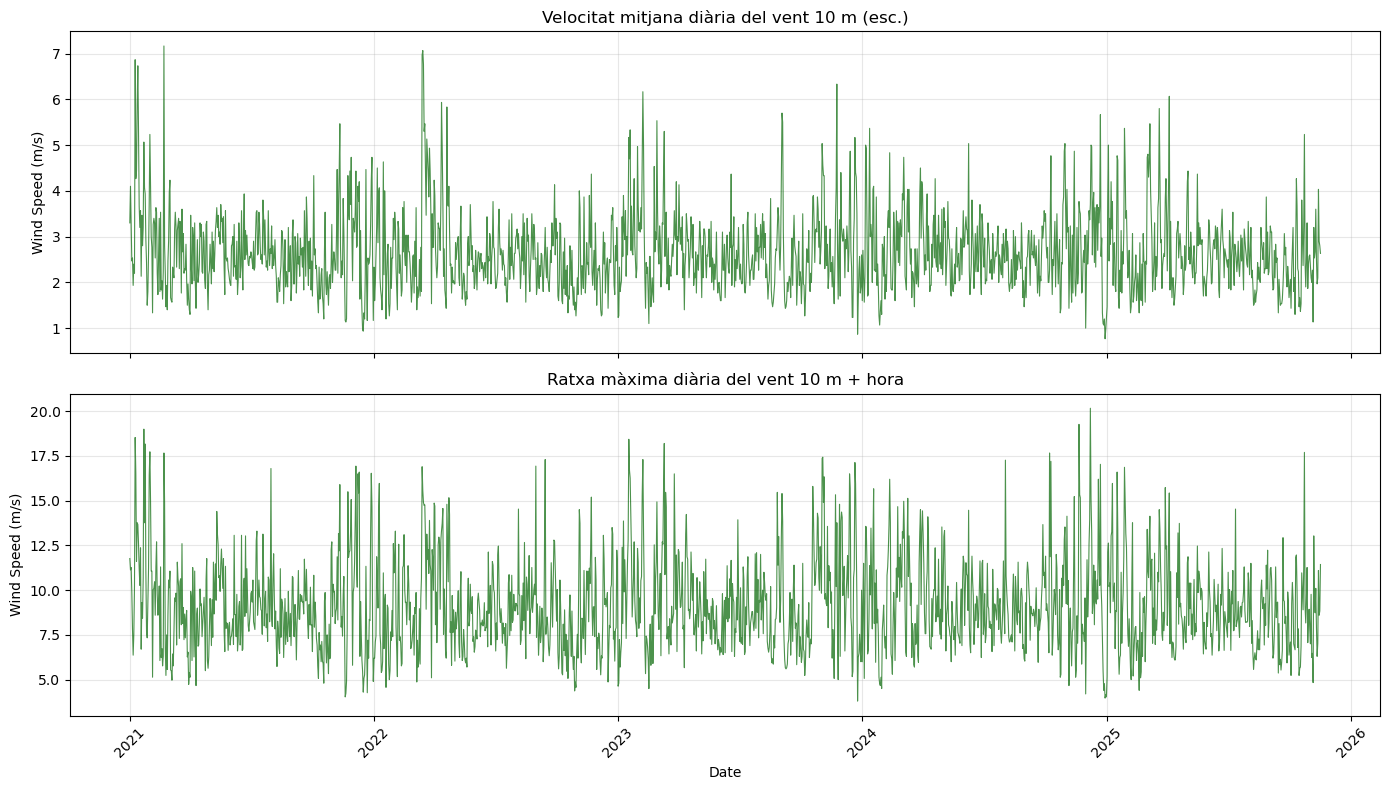

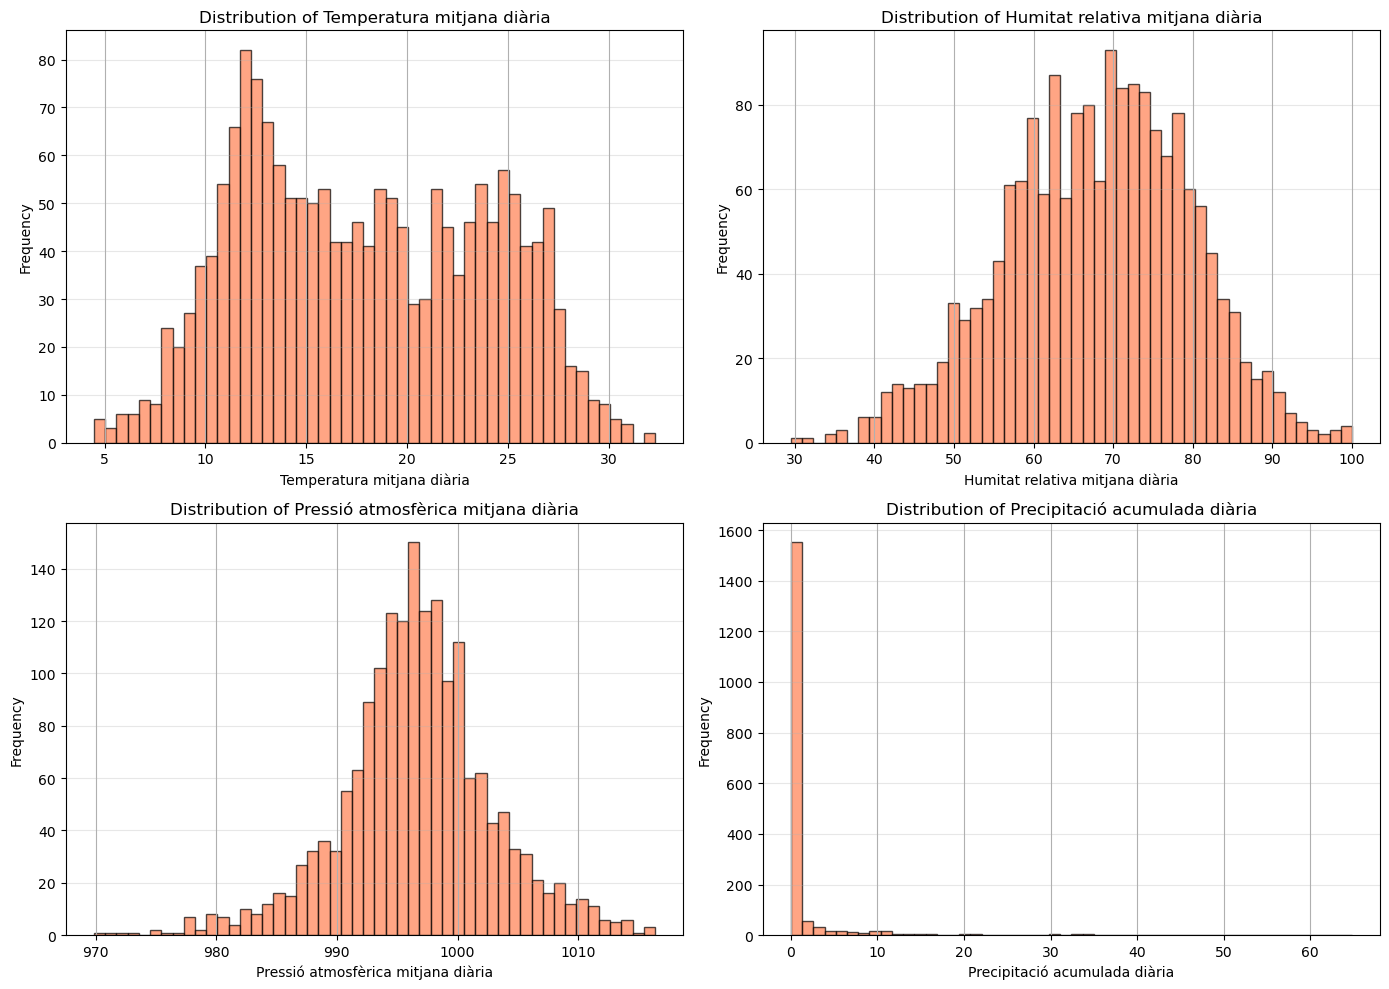

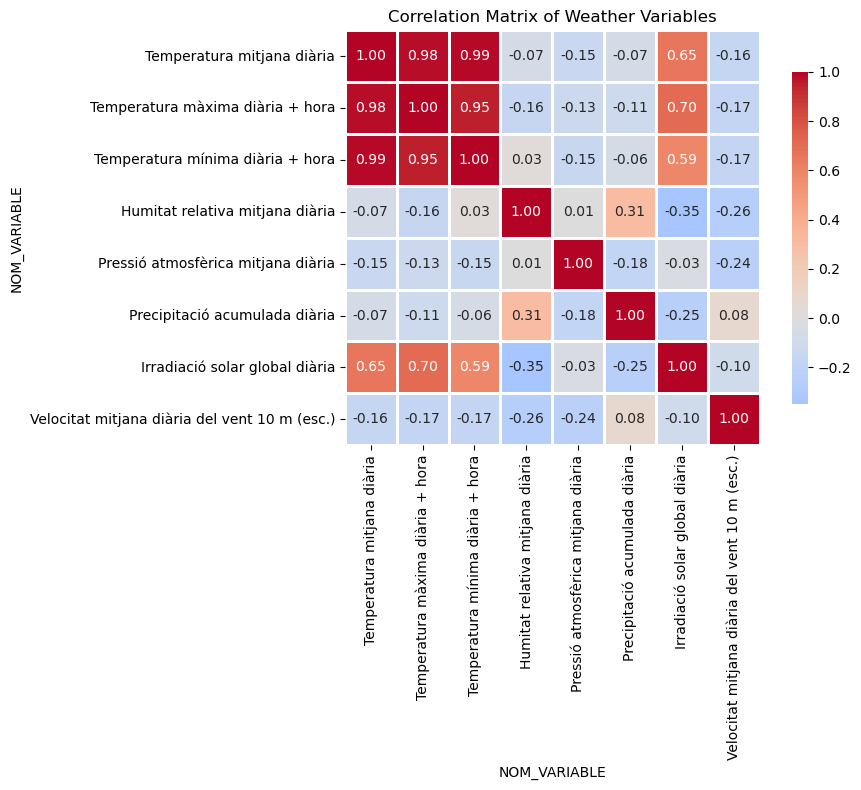

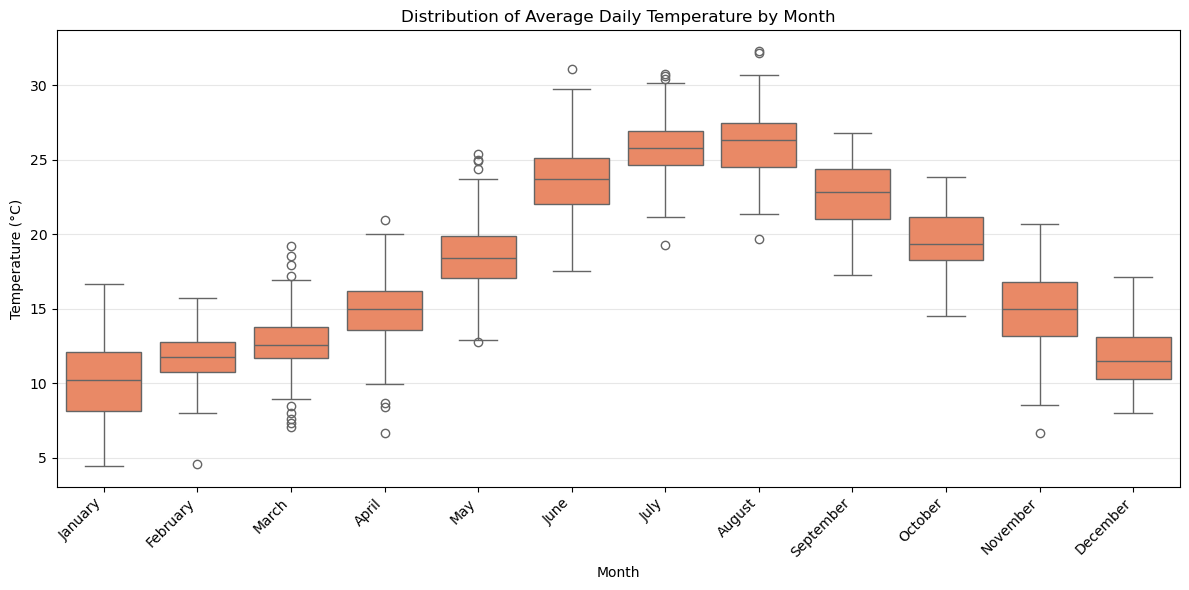

In [24]:
# Load cleaned weather data
df_weather_clean = pd.read_parquet("clean/weather_clean.parquet")

# Convert DATA_LECTURA to datetime
df_weather_clean['DATA_LECTURA'] = pd.to_datetime(df_weather_clean['DATA_LECTURA'], format="%d/%m/%Y", errors='coerce')

# Identify rows with incorrect NOM_VARIABLE values
print("=" * 80)
print("ROWS WITH INCORRECT NOM_VARIABLE VALUES")
print("=" * 80)

# List of correct NOM_VARIABLE values
correct_vars = [
    'Temperatura mitjana diària',
    'Temperatura màxima diària + hora',
    'Temperatura mínima diària + hora',
    'Temperatura mitjana diària clàssica',
    'Amplitud tèrmica diària',
    'Humitat relativa mitjana diària',
    'Humitat relativa màxima diària + data',
    'Humitat relativa mínima diària + data',
    'Pressió atmosfèrica mitjana diària',
    'Pressió atmosfèrica màxima diària + hora',
    'Pressió atmosfèrica mínima diària + hora',
    'Precipitació acumulada diària',
    'Precipitació acumulada diària (8-8 h)',
    'Precipitació màxima en 1 min (diària) + hora',
    'Precipitació màxima en 1 h (diària) + hora',
    'Precipitació màxima en 30 min (diària)+ hora',
    'Irradiació solar global diària',
    'Velocitat mitjana diària del vent 10 m (esc.)',
    'Direcció mitjana diària del vent 10 m (m. 1)',
    'Ratxa màxima diària del vent 10 m + hora',
    'Direcció de la ratxa màx. diària de vent 10 m',
    'Evapotranspiració de referència',
    'Velocitat mitjana diària del vent 10 m (vec.)',
    'Direcció mitjana diària del vent 10 m (m. u)'
]

# Filter rows where NOM_VARIABLE is NOT in the correct list
if 'NOM_VARIABLE' in df_weather_clean.columns:
    incorrect_mask = ~df_weather_clean['NOM_VARIABLE'].isin(correct_vars)
    df_incorrect = df_weather_clean[incorrect_mask].copy()
    
    print(f"\nTotal rows with incorrect NOM_VARIABLE: {len(df_incorrect):,}")
    print(f"Total rows in dataset: {len(df_weather_clean):,}")
    print(f"Percentage incorrect: {len(df_incorrect)/len(df_weather_clean)*100:.4f}%")
    
    if len(df_incorrect) > 0:
        print(f"\nIncorrect variable names found:")
        incorrect_counts = df_incorrect['NOM_VARIABLE'].value_counts().sort_index()
        for var, count in incorrect_counts.items():
            print(f"  - '{var}': {count} records")
        
        print(f"\nAll rows with incorrect NOM_VARIABLE:")
        print(df_incorrect.to_string())
        
        print(f"\nSummary by incorrect variable:")
        summary = df_incorrect.groupby('NOM_VARIABLE').size().reset_index(name='count').sort_values('NOM_VARIABLE')
        print(summary.to_string(index=False))
    else:
        print("\n✓ All rows have correct NOM_VARIABLE values")
else:
    print("⚠ Column 'NOM_VARIABLE' not found in weather data")

print("\n" + "=" * 80)

# Ensure numeric 'VALOR_NUM' column is present
if 'VALOR_NUM' not in df_weather_clean.columns and 'VALOR' in df_weather_clean.columns:
    df_weather_clean['VALOR_NUM'] = (
        df_weather_clean['VALOR']
        .astype(str)
        .str.replace('.', '', regex=False)
        .str.replace(',', '.', regex=False)
    )
    df_weather_clean['VALOR_NUM'] = pd.to_numeric(df_weather_clean['VALOR_NUM'], errors='coerce')

print(f"Weather data shape: {df_weather_clean.shape}")
print(f"Date range: {df_weather_clean['DATA_LECTURA'].min()} to {df_weather_clean['DATA_LECTURA'].max()}")
print(f"Available columns: {df_weather_clean.columns.tolist()}")

# Focus on key temperature variables
variable_map = {
    'Temperatura màxima diària + hora': 'temp_max',
    'Temperatura mínima diària + hora': 'temp_min',
    'Temperatura mitjana diària': 'temp_avg'
}

# Create comprehensive weather analysis with multiple variables
print("\n" + "=" * 80)
print("COMPREHENSIVE WEATHER DATA ANALYSIS")
print("=" * 80)

# Pivot all weather variables to wide format for analysis
weather_pivot = (
    df_weather_clean
    .pivot_table(
        index='DATA_LECTURA', 
        columns='NOM_VARIABLE', 
        values='VALOR_NUM', 
        aggfunc='mean'
    )
    .reset_index()
    .sort_values('DATA_LECTURA')
)

print(f"\nPivoted weather data (all variables): {weather_pivot.shape}")
print(f"Variables: {list(weather_pivot.columns[1:])}")

# 1. Temperature, Humidity, and Pressure over time (multi-panel)
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Temperature
temp_vars = ['Temperatura màxima diària + hora', 'Temperatura mínima diària + hora', 'Temperatura mitjana diària']
for var in temp_vars:
    if var in weather_pivot.columns:
        axes[0].plot(weather_pivot['DATA_LECTURA'], weather_pivot[var], label=var, linewidth=0.8, alpha=0.7)
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature Trends Over Time')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Humidity
humidity_vars = ['Humitat relativa màxima diària + data', 'Humitat relativa mínima diària + data', 'Humitat relativa mitjana diària']
for var in humidity_vars:
    if var in weather_pivot.columns:
        axes[1].plot(weather_pivot['DATA_LECTURA'], weather_pivot[var], label=var, linewidth=0.8, alpha=0.7)
axes[1].set_ylabel('Humidity (%)')
axes[1].set_title('Humidity Trends Over Time')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

# Pressure
pressure_vars = ['Pressió atmosfèrica màxima diària + hora', 'Pressió atmosfèrica mínima diària + hora', 'Pressió atmosfèrica mitjana diària']
for var in pressure_vars:
    if var in weather_pivot.columns:
        axes[2].plot(weather_pivot['DATA_LECTURA'], weather_pivot[var], label=var, linewidth=0.8, alpha=0.7)
axes[2].set_ylabel('Pressure (hPa)')
axes[2].set_xlabel('Date')
axes[2].set_title('Atmospheric Pressure Trends Over Time')
axes[2].legend(fontsize=8)
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Seasonal patterns - Monthly averages for key variables
weather_pivot['year'] = weather_pivot['DATA_LECTURA'].dt.year
weather_pivot['month'] = weather_pivot['DATA_LECTURA'].dt.month
weather_pivot['month_name'] = weather_pivot['DATA_LECTURA'].dt.strftime('%B')

# Monthly averages for temperature
monthly_temp = weather_pivot.groupby('month').agg({
    'Temperatura màxima diària + hora': 'mean',
    'Temperatura mínima diària + hora': 'mean',
    'Temperatura mitjana diària': 'mean'
}).reset_index()
monthly_temp['month_name'] = pd.to_datetime(monthly_temp['month'], format='%m').dt.strftime('%B')
monthly_temp = monthly_temp.sort_values('month')

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(monthly_temp))
width = 0.25
if 'Temperatura màxima diària + hora' in monthly_temp.columns:
    ax.bar([i - width for i in x], monthly_temp['Temperatura màxima diària + hora'], width, label='Max', color='tomato', alpha=0.8)
if 'Temperatura mitjana diària' in monthly_temp.columns:
    ax.bar(x, monthly_temp['Temperatura mitjana diària'], width, label='Average', color='seagreen', alpha=0.8)
if 'Temperatura mínima diària + hora' in monthly_temp.columns:
    ax.bar([i + width for i in x], monthly_temp['Temperatura mínima diària + hora'], width, label='Min', color='royalblue', alpha=0.8)

ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Average Monthly Temperature Patterns')
ax.set_xticks(x)
ax.set_xticklabels(monthly_temp['month_name'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 3. Precipitation analysis
if 'Precipitació acumulada diària' in weather_pivot.columns:
    precip_data = weather_pivot[['DATA_LECTURA', 'Precipitació acumulada diària']].dropna()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Daily precipitation
    axes[0].plot(precip_data['DATA_LECTURA'], precip_data['Precipitació acumulada diària'], 
                 color='steelblue', linewidth=0.5, alpha=0.6)
    axes[0].set_ylabel('Daily Precipitation (mm)')
    axes[0].set_title('Daily Precipitation Over Time')
    axes[0].grid(True, alpha=0.3)
    
    # Monthly total precipitation
    precip_data['year'] = precip_data['DATA_LECTURA'].dt.year
    precip_data['month'] = precip_data['DATA_LECTURA'].dt.month
    monthly_precip = precip_data.groupby(['year', 'month'])['Precipitació acumulada diària'].sum().reset_index()
    monthly_precip['date'] = pd.to_datetime(monthly_precip[['year', 'month']].assign(day=1))
    monthly_precip = monthly_precip.sort_values('date')
    
    axes[1].bar(monthly_precip['date'], monthly_precip['Precipitació acumulada diària'], 
                color='steelblue', alpha=0.7, width=20)
    axes[1].set_ylabel('Monthly Total Precipitation (mm)')
    axes[1].set_xlabel('Date')
    axes[1].set_title('Monthly Total Precipitation')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPrecipitation statistics:")
    print(precip_data['Precipitació acumulada diària'].describe())

# 4. Wind analysis
wind_vars = ['Velocitat mitjana diària del vent 10 m (esc.)', 'Ratxa màxima diària del vent 10 m + hora']
wind_data = weather_pivot[['DATA_LECTURA'] + [v for v in wind_vars if v in weather_pivot.columns]].dropna()

if len(wind_data.columns) > 1:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    for i, var in enumerate([v for v in wind_vars if v in weather_pivot.columns]):
        axes[i].plot(wind_data['DATA_LECTURA'], wind_data[var], linewidth=0.8, alpha=0.7, color='darkgreen')
        axes[i].set_ylabel('Wind Speed (m/s)')
        axes[i].set_title(var)
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Date')
    axes[-1].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# 5. Distribution of key variables
key_vars_for_dist = [
    'Temperatura mitjana diària',
    'Humitat relativa mitjana diària',
    'Pressió atmosfèrica mitjana diària',
    'Precipitació acumulada diària'
]

dist_data = weather_pivot[['DATA_LECTURA'] + [v for v in key_vars_for_dist if v in weather_pivot.columns]].dropna()

if len(dist_data.columns) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, var in enumerate([v for v in key_vars_for_dist if v in weather_pivot.columns]):
        if i < len(axes):
            dist_data[var].hist(bins=50, ax=axes[i], color='coral', alpha=0.7, edgecolor='black')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frequency')
            axes[i].set_title(f'Distribution of {var}')
            axes[i].grid(True, alpha=0.3, axis='y')
    
    # Hide unused subplots
    for i in range(len([v for v in key_vars_for_dist if v in weather_pivot.columns]), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# 6. Correlation heatmap between weather variables
correlation_vars = [
    'Temperatura mitjana diària',
    'Temperatura màxima diària + hora',
    'Temperatura mínima diària + hora',
    'Humitat relativa mitjana diària',
    'Pressió atmosfèrica mitjana diària',
    'Precipitació acumulada diària',
    'Irradiació solar global diària',
    'Velocitat mitjana diària del vent 10 m (esc.)'
]

corr_data = weather_pivot[[v for v in correlation_vars if v in weather_pivot.columns]].dropna()

if len(corr_data.columns) > 1:
    corr_matrix = corr_data.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Weather Variables')
    plt.tight_layout()
    plt.show()

# 7. Box plots by month for temperature
if 'Temperatura mitjana diària' in weather_pivot.columns:
    temp_monthly = weather_pivot[['DATA_LECTURA', 'Temperatura mitjana diària', 'month', 'month_name']].dropna()
    temp_monthly = temp_monthly.sort_values('month')
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=temp_monthly, x='month_name', y='Temperatura mitjana diària', 
                order=temp_monthly.sort_values('month')['month_name'].unique(), color='coral')
    plt.title('Distribution of Average Daily Temperature by Month')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()